<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - LDA
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)


# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

C:\Users\Hallk\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the fully preprocessed data
def read_preprocessed(language, tokenize = True):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/"+language+"_preprocessed.csv"

    # Read in the dataframe containing the text data
    tx_pp = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_pp.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Reduce the dataframe to a list containing the text data
    tx_pp = tx_pp.tx.to_list()

    # Tokenize the data again if tokenize = True (RAM-saving)
    if tokenize:
        tx_pp = retokenize(tx_pp)

    # Return the preprocessed data
    return tx_pp, idx

# Define a function to retokenize the preprocessed text data (RAM-saving)
def retokenize(article_list):
    for i in range(len(article_list)):
        temp_tx = str(article_list[i]).split()
        article_list[i] = temp_tx
    return article_list

In [4]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Fulltext/"+language+"_fulltext.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [5]:
# Read in the preprocessed data
de_tx, de_idx = read_preprocessed('de')

# Take a look at the size of the precleaned data
sys.getsizeof(de_tx)

15474568

In [6]:
# Take a look at the preprocessed data
de_tx[0][:6]

['rückkehrer', 'stefan', 'meier', 'überragen', 'flames', 'herisau']

In [7]:
# Take a look at the dataframe containing the according index
de_idx.tail(3)

,de_idx
1934310,2441180
1934311,2441181
1934312,2441182


In [8]:
# Retrieve the location of the article in the preprocessed data using the according article id
article_ids = [2441180, 2441181]
location = de_idx[de_idx.de_idx.isin(article_ids)].index.tolist() #1934310

# Access the preprocessed text from the articles with the article ids in [2441180, 2441181]
#list(de_tx[i] for i in location)

# Look at the according location of the articles with the article ids in [2441180, 2441181]
location

[1934310, 1934311]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary and the corpus. So let's create them subsequently

In [9]:
# Create Dictionary
dictionary = corpora.Dictionary(de_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(de_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2520

In [10]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in de_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 2), (57, 15), (58, 2), (59, 1), (60, 1), (61, 1), (62, 4), (63, 4), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 3), (75, 3), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 4), (95, 1), (96, 1), (97, 3), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [11]:
# Remove unnecessary variables to save RAM
del de_tx, de_idx

Note: 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- To see what word a given id corresponds to, pass the id as a key to the dictionary.

In [12]:
# Get the phrase corresponding to id 0
dictionary[0]

'aktuell'

In [13]:
# Get a human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aktuell', 1),
  ('allgemein', 1),
  ('auftritt', 1),
  ('ausgleich', 1),
  ('ball', 2),
  ('behaupten', 1),
  ('bekommen', 1),
  ('belegen', 1),
  ('berücksichtigen', 1),
  ('bestätigen', 1),
  ('betreffen', 1),
  ('bewegen', 1),
  ('bild', 1),
  ('brand', 2),
  ('bringen', 1),
  ('corona', 1),
  ('deutlich', 1),
  ('drohen', 1),
  ('eindrücklich', 1),
  ('einfach', 1),
  ('einzig', 1),
  ('entscheid', 1),
  ('erfolg', 1),
  ('erhoffen', 1),
  ('erstaunlich', 1),
  ('erzielen', 1),
  ('führung', 2),
  ('gastgeber', 1),
  ('gelingen', 1),
  ('genau', 1),
  ('gewicht', 2),
  ('grossem', 1),
  ('gruppe', 2),
  ('grösse', 1),
  ('heimspiel', 1),
  ('hiess', 1),
  ('jahrelang', 1),
  ('jung', 1),
  ('jährig', 1),
  ('karriere', 1),
  ('kehren', 1),
  ('kein', 1),
  ('kennen', 1),
  ('kino', 2),
  ('kommen', 1),
  ('kurzfristig', 1),
  ('können', 1),
  ('lagen', 1),
  ('lassen', 1),
  ('laufen', 1),
  ('leben', 1),
  ('letzt', 1),
  ('liegen', 1),
  ('liga', 2),
  ('lukas', 2),
  ('mache

In [14]:
# Search for a specific word (here: corona & covid) in the preprocessed dictionary
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break   

At pos. 15 we find the word corona
At pos. 1396 we find the word covid


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Building the Topic Model</h2>
</div>

Now we have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics K and several further hyperparameters as well. To choose the hyperparameters other than the number of topics and the number of passes, we rely on the suggestions given either by Hoffman, Bach & Blei (2010) (for workers, chunksize, offset, decay and eval_every) or by the default settings of the model (for alpha, eta and minimum_probability). The parameter "passes" is chosen such that the model can be trained reasonable and feasible amount of time. The random state to generate the initial model parameters is set to 7.

Parameters overview:

- workers: number of cpu cores to use for computation (optimal performance if it is set to # of REAL cores - 1)
- num_topics: number of topics to distinguish
- chunksize: number of documents to be used in each training chunk (corresponds to batchsize/workers)
- passes: total number of training passes (comparable to epochs in ANN)
- alpha: a 1D array of length equal to the number of expected topics that expresses our a-priori belief on each topic probability (default = 'symmetric' $\rightarrow$ corresponds to 1/num_topics)
- eta: a-priori belief on word probability (either overall or topic specific) (default = None $\rightarrow$ corresponds 1/num_words for all topics $\rightarrow$ $\beta$ in Hoffman, Bach & Blei (2010))
- minimum_probability: topics with a probability lower than this threshold will be filtered out
- offset: corresponds to $\tau_0$ in Hoffman, Bach & Blei (2010) (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- decay: corresponds to $\kappa$ in Hoffman, Bach & Blei (2010). It should be chosen such that $\kappa \in (0.5,1]$ to guarantee convergence. (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- eval_every: The performance of the model (measured using the log-perplexity) is estimated every eval_every updates. It corresponds to the batchsize in Hoffman, Bach & Blei (2010) (approximately chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)

In [15]:
# Build LDA model paralellized
t = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                    id2word             = dictionary,
                                                    workers             = 5,
                                                    num_topics          = 25,
                                                    chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                    passes              = 12, 
                                                    alpha               = 'symmetric',
                                                    eta                 = None,
                                                    minimum_probability = 0.01,
                                                    offset              = 64,
                                                    decay               = 0.5,
                                                    eval_every          = 4095,
                                                    random_state        = 7,
                                                    per_word_topics     = True)
print("Processing time to build the LDA model paralellized: ", str((time.time() - t)/60), "minutes")

Processing time to build the LDA model paralellized:  60.33237167199453 minutes


In [16]:
# Save the model to harddisk
lda_model.save("LDA/de_lda_model_"+str(lda_model.num_topics)+"_topics")

In [18]:
# Delete unnecessary variables (stored as modelname.id2word)
del dictionary

In [17]:
##### Update model using new, unseen documents (Example) #####
#other_texts = [
#    ['computer', 'time', 'graph'],
#    ['survey', 'response', 'eps'],
#    ['human', 'system', 'computer']
#]
#other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

#unseen_doc = other_corpus[0]
#vector = lda_model[unseen_doc]  # get topic probability distribution for a document

# Update the model by incrementally training on the new corpus.
#lda_model.update(other_corpus)  # update the LDA model with additional documents

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. View the topics in the LDA model</h2>
</div>

The above LDA model is built with a predetermined number of different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. Thus, we can visualize the keywords for each topic and the weightage (importance) of each keyword as follows.

In [5]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/de_lda_model_25_topics")         # adjust the digit appropriately

In [6]:
# Print the 10 most important keywords for each topic
pprint(lda_model.print_topics())

[(23,
  '0.031*"polizei" + 0.027*"auto" + 0.015*"kantonspolizei" + 0.015*"mann" + '
  '0.014*"fahrzeug" + 0.014*"verletzen" + 0.014*"sda" + 0.013*"sbb" + '
  '0.013*"jährig" + 0.012*"fahren"'),
 (0,
  '0.175*"kanton" + 0.084*"luzern" + 0.069*"zürich" + 0.049*"bern" + '
  '0.038*"basel" + 0.035*"zug" + 0.034*"galle" + 0.034*"stadt" + '
  '0.033*"luzerner" + 0.019*"zürcher"'),
 (4,
  '0.024*"haus" + 0.020*"gast" + 0.019*"restaurant" + 0.018*"hotel" + '
  '0.016*"wohnung" + 0.014*"stadt" + 0.013*"stehen" + 0.009*"ort" + '
  '0.009*"essen" + 0.008*"bild"'),
 (13,
  '0.018*"fall" + 0.014*"mann" + 0.014*"gericht" + 0.013*"frau" + '
  '0.009*"staatsanwaltschaft" + 0.009*"vorwurf" + 0.009*"urteil" + '
  '0.008*"schreiben" + 0.008*"opfer" + 0.008*"behörde"'),
 (21,
  '0.021*"präsident" + 0.014*"peter" + 0.014*"müller" + 0.013*"mitglied" + '
  '0.013*"übernehmen" + 0.011*"thoma" + 0.011*"neu" + 0.010*"andrea" + '
  '0.010*"martin" + 0.010*"amt"'),
 (15,
  '0.033*"minute" + 0.027*"tor" + 0.025*"s

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Compute Model Perplexity and Coherence Score</h2>
</div>

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) (as explained in Röder, Both & Hinneburg (2015)) provide a convenient measure to judge how good a given topic model is. (Experience has shown that topic coherence score, in particular, has been more helpful)

In [7]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/de_lda_model_25_topics")         # adjust the digit appropriately

In [8]:
# Read in the preprocessed data
de_tx = read_preprocessed('de')[0]

In [9]:
# Create the corpus again
corpus = [lda_model.id2word.doc2bow(article) for article in de_tx]

In [10]:
# Compute Perplexity
print('Perplexity of the LDA model with', str(lda_model.num_topics), 'topics:', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

Perplexity of the LDA model with 25 topics: -7.047010047401373


In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = de_tx, dictionary = lda_model.id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of the LDA model with', str(lda_model.num_topics), 'topics:', coherence_lda)

Coherence Score of the LDA model with 25 topics: 0.6009025786399249


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.127601 -0.070165       1        1  11.019832
14    -0.071997 -0.126737       2        1   6.719302
1     -0.002522 -0.104339       3        1   5.743175
5      0.144420  0.004615       4        1   5.422263
6     -0.081440 -0.078576       5        1   5.389997
19    -0.104932 -0.082536       6        1   4.721282
13    -0.027705 -0.064261       7        1   4.520831
10    -0.059271 -0.069542       8        1   4.475482
11    -0.098225 -0.058032       9        1   4.445628
17    -0.098641 -0.027128      10        1   3.652395
9     -0.001870 -0.106041      11        1   3.613070
2      0.054572 -0.044687      12        1   3.506401
3      0.131275  0.107093      13        1   3.354099
15     0.151233  0.093075      14        1   3.298891
21     0.012518  0.056659      15        1   3.136290
4      0.077028  0.066932      16        1   3.124743
18    -0.201846 -0.070564      17        1   2.991843
20     0.170567  0.081893      18        1   2.896931
8      0.039014  0.078734      19        1   2.855705
12     0.094685 -0.053140      20        1   2.831630
22    -0.146671 -0.020051      21        1   2.802078
24     0.015332 -0.102007      22        1   2.783997
23    -0.048558  0.091974      23        1   2.721961
16     0.172754  0.089310      24        1   2.199315
0     -0.247323  0.407521      25        1   1.772858, topic_info=        Term          Freq         Total Category  logprob  loglift
202   franke  9.251320e+05  9.251320e+05  Default  30.0000  30.0000
218   kanton  8.722800e+05  8.722800e+05  Default  29.0000  29.0000
331  prozent  1.293165e+06  1.293165e+06  Default  28.0000  28.0000
226  million  7.537990e+05  7.537990e+05  Default  27.0000  27.0000
248  schweiz  1.198860e+06  1.198860e+06  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
811  zürcher  7.330260e+04  2.188590e+05  Topic25  -3.9451   2.9387
256    stadt  1.284832e+05  4.397051e+05  Topic25  -3.3839   2.8023
911   region  3.059149e+04  2.206952e+05  Topic25  -4.8190   2.0565
248  schweiz  4.050674e+04  1.198860e+06  Topic25  -4.5382   0.6449
779   person  2.769696e+04  5.059802e+05  Topic25  -4.9184   1.1274

[1228 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1156      2  0.011056       aarau
1156      8  0.003622       aarau
1156     13  0.329556       aarau
1156     14  0.098205       aarau
1156     19  0.118792       aarau
...     ...       ...         ...
718      17  0.071446  übernehmen
718      18  0.015089  übernehmen
718      19  0.003418  übernehmen
718      20  0.019023  übernehmen
718      22  0.011149  übernehmen

[8969 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 15, 2, 6, 7, 20, 14, 11, 12, 18, 10, 3, 4, 16, 22, 5, 19, 21, 9, 13, 23, 25, 24, 17, 1])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Find the optimal number of topics (K) for the LDA model </h2>
</div>

To find the optimal number of topics K for our LDA model, we set up a function to train multiple LDA models for differnet values of K, while keeping track of the processing time and the according coherence scores. A commonly applied method to identify the optimal K then is to choose the model according to one of the following two criterions:

1. Choose K such that the coherence score is maximized (can sometimes provide too granular sub-topics)

2. Choose the model which indicates the end of a steep growth in terms of the coherence score (usually offers meaningful and interpretable topics)

However, to evaluate the quality of the topic models later on we then additionally consider similarities in the top ranked keywords among the resulting topics. Observing that the exact same keyword appears at a high ranking in multiple topics would be an indicator that the chosen K is probably too large. The similarity among the resulting topics can then be assessed by means of the so called Jaccardian similarity, whose concept is introduced in greater detail in Section 7.3.

In [5]:
# Read in the preprocessed data
de_tx = read_preprocessed('de')[0]

In [6]:
# Create Dictionary
dictionary = corpora.Dictionary(de_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 70% of the articles, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(de_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2515

In [7]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in de_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 2), (54, 1), (55, 2), (56, 15), (57, 2), (58, 1), (59, 1), (60, 1), (61, 4), (62, 1), (63, 1), (64, 2), (65, 2), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 3), (73, 3), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 4), (93, 1), (94, 1), (95, 3), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 3), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1)]]


In [8]:
# Remove unnecessary variables to save RAM
del de_tx

In [9]:
def compare_lda_models(dictionary, corpus, min_k = 5, max_k = 35, step = 5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    min_k : Min num of topics
    max_k : Max num of topics
    step : Steps to increase the number of topics in each iteration

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    processing_times : Processing time corresponding to the training of the LDA model with respective number of topics
    n_topics : The grid of number of topics over which differnet models are trained
    """
    # Create empty lists to store the output
    coherence_values = []
    processing_times = []
    n_topics = []

    # Set up a loop to train the different models and compute the according processing time
    for num_topics in range(min_k, max_k+1, step):
        # Train the LdaMulticore model while keeping track of the processing time
        t = time.time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                            id2word             = dictionary,
                                                            workers             = 5,
                                                            num_topics          = num_topics,
                                                            chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                            passes              = 12, 
                                                            alpha               = 'symmetric',
                                                            eta                 = None,
                                                            minimum_probability = 0.01,
                                                            offset              = 64,
                                                            decay               = 0.5,
                                                            eval_every          = 4095,
                                                            random_state        = 7,
                                                            per_word_topics     = True)
        t_training = (time.time() - t)/60
        print("Processing time to build the LDA multicore model with", str(num_topics), "topics:", str(t_training), "minutes")

        # Safe the trained model to harddisk
        lda_model.save("LDA/de_lda_model_"+str(lda_model.num_topics)+"_topics") # Adjust the according language

        # Compute the cohorence score
        coherence_model_lda = CoherenceModel(model = lda_model, texts = read_preprocessed('de')[0], dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Coherence Score of the LDA multicore model with", str(num_topics), "topics:", coherence_lda)

        # Store the coherence score and the computing time
        coherence_values.append(coherence_lda)
        processing_times.append(t_training)
        
        # Store the number of topics
        n_topics.append(num_topics)

    # Return the coherence values, the processing times and the corresponding number of topics applied
    return coherence_values, processing_times, n_topics

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.1 Estimate multiple LDA models for varying number of topics K </h2>
</div>

In [10]:
# 1. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, min_k = 5, max_k = 45, step = 10)

Processing time to build the LDA multicore model with 5 topics: 59.8154326359431 minutes
Coherence Score of the LDA multicore model with 5 topics: 0.5436379782652139
Processing time to build the LDA multicore model with 15 topics: 63.79806190729141 minutes
Coherence Score of the LDA multicore model with 15 topics: 0.5616005246306605
Processing time to build the LDA multicore model with 25 topics: 67.81888985236486 minutes
Coherence Score of the LDA multicore model with 25 topics: 0.6009025786399249
Processing time to build the LDA multicore model with 35 topics: 94.76175772746404 minutes
Coherence Score of the LDA multicore model with 35 topics: 0.6073096727493481
Processing time to build the LDA multicore model with 45 topics: 78.93791459004085 minutes
Coherence Score of the LDA multicore model with 45 topics: 0.6094793929624562


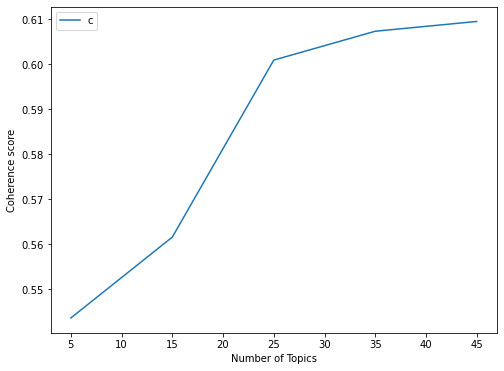

In [11]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

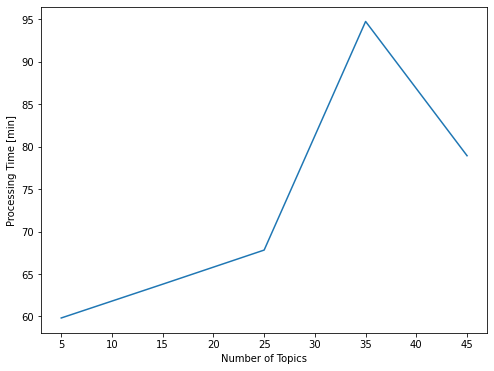

In [12]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [13]:
# Take a look at the resulting coherence scores
coherence_values

[0.5436379782652139,
 0.5616005246306605,
 0.6009025786399249,
 0.6073096727493481,
 0.6094793929624562]

In [14]:
# Take a look at the required processing times (in minutes)
processing_times

[59.8154326359431,
 63.79806190729141,
 67.81888985236486,
 94.76175772746404,
 78.93791459004085]

In [15]:
# Take a look at the grid of the number of topics
n_topics

[5, 15, 25, 35, 45]

In [10]:
## 2. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, min_k = 20, max_k = 50, step = 10)

Processing time to build the LDA multicore model with 20 topics: 62.90475906133652 minutes
Coherence Score of the LDA multicore model with 20 topics: 0.591490064818739
Processing time to build the LDA multicore model with 30 topics: 67.44095472097396 minutes
Coherence Score of the LDA multicore model with 30 topics: 0.6017499571769517
Processing time to build the LDA multicore model with 40 topics: 95.74181473255157 minutes
Coherence Score of the LDA multicore model with 40 topics: 0.6128308575352752
Processing time to build the LDA multicore model with 50 topics: 80.58396632671356 minutes
Coherence Score of the LDA multicore model with 50 topics: 0.6013447159566319


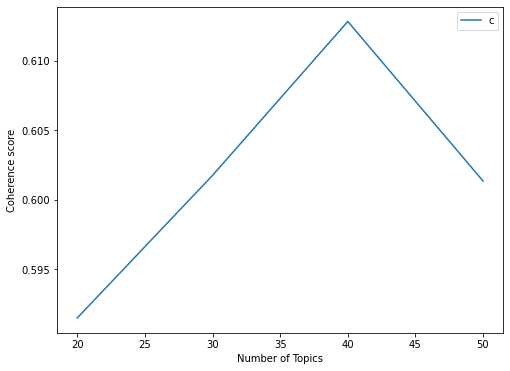

In [11]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

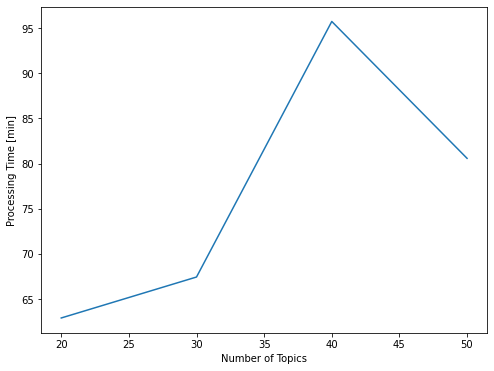

In [12]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [13]:
# Take a look at the resulting coherence scores
coherence_values

[0.591490064818739, 0.6017499571769517, 0.6128308575352752, 0.6013447159566319]

In [14]:
# Take a look at the required processing times (in minutes)
processing_times

[62.90475906133652, 67.44095472097396, 95.74181473255157, 80.58396632671356]

In [15]:
# Take a look at the grid of the number of topics
n_topics

[20, 30, 40, 50]

In [10]:
## 3. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, min_k = 21, max_k = 24, step = 1)

Processing time to build the LDA multicore model with 21 topics: 59.06168606678645 minutes
Coherence Score of the LDA multicore model with 21 topics: 0.5894477507433086
Processing time to build the LDA multicore model with 22 topics: 60.60930094718933 minutes
Coherence Score of the LDA multicore model with 22 topics: 0.5834186056684021
Processing time to build the LDA multicore model with 23 topics: 60.5884538213412 minutes
Coherence Score of the LDA multicore model with 23 topics: 0.5913771484468056
Processing time to build the LDA multicore model with 24 topics: 60.68564414183299 minutes
Coherence Score of the LDA multicore model with 24 topics: 0.590845458496003


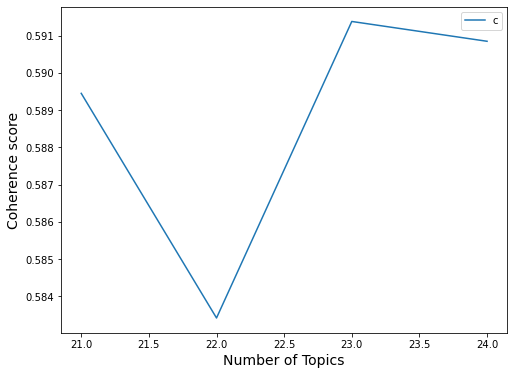

In [11]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

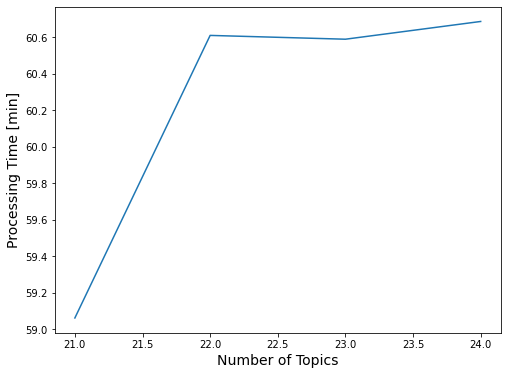

In [12]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [13]:
# Take a look at the resulting coherence scores
coherence_values

[0.5894477507433086, 0.5834186056684021, 0.5913771484468056, 0.590845458496003]

In [14]:
# Take a look at the required processing times (in minutes)
processing_times

[59.06168606678645, 60.60930094718933, 60.5884538213412, 60.68564414183299]

In [15]:
# Take a look at the grid of the number of topics
n_topics

[21, 22, 23, 24]

In [16]:
## 4. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, min_k = 26, max_k = 29, step = 1)

Processing time to build the LDA multicore model with 26 topics: 66.64551583925883 minutes
Coherence Score of the LDA multicore model with 26 topics: 0.6031192464253451
Processing time to build the LDA multicore model with 27 topics: 61.93940903743108 minutes
Coherence Score of the LDA multicore model with 27 topics: 0.5947736802505857
Processing time to build the LDA multicore model with 28 topics: 62.77810864845912 minutes
Coherence Score of the LDA multicore model with 28 topics: 0.60564626991718
Processing time to build the LDA multicore model with 29 topics: 62.763796929518385 minutes
Coherence Score of the LDA multicore model with 29 topics: 0.6040389470852532


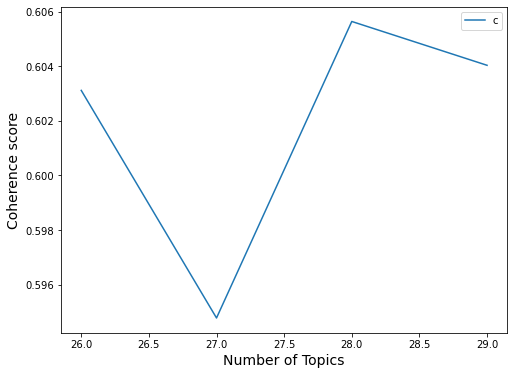

In [17]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

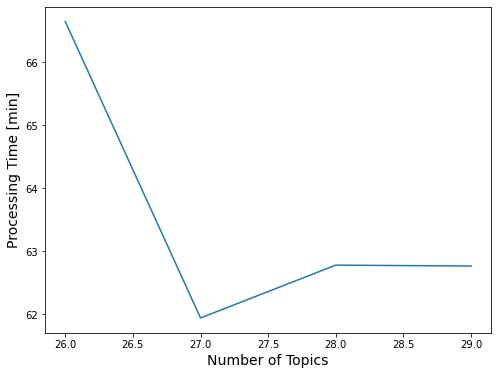

In [18]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [19]:
# Take a look at the resulting coherence scores
coherence_values

[0.6031192464253451, 0.5947736802505857, 0.60564626991718, 0.6040389470852532]

In [20]:
# Take a look at the required processing times (in minutes)
processing_times

[66.64551583925883, 61.93940903743108, 62.77810864845912, 62.763796929518385]

In [21]:
# Take a look at the grid of the number of topics
n_topics

[26, 27, 28, 29]

In [22]:
## 5. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, min_k = 31, max_k = 34, step = 1)

Processing time to build the LDA multicore model with 31 topics: 68.4912020166715 minutes
Coherence Score of the LDA multicore model with 31 topics: 0.6157259960993569
Processing time to build the LDA multicore model with 32 topics: 66.33860891660055 minutes
Coherence Score of the LDA multicore model with 32 topics: 0.5942393496135262
Processing time to build the LDA multicore model with 33 topics: 86.35362824996312 minutes
Coherence Score of the LDA multicore model with 33 topics: 0.605285254354468
Processing time to build the LDA multicore model with 34 topics: 93.47155125141144 minutes
Coherence Score of the LDA multicore model with 34 topics: 0.5962808492435416


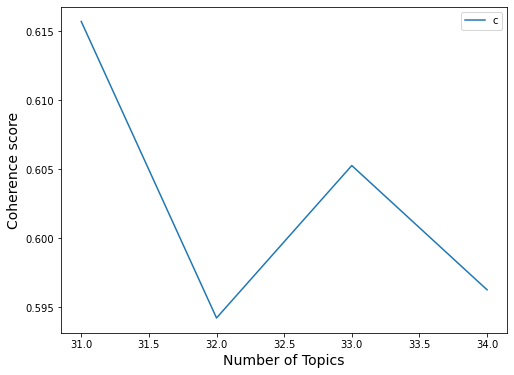

In [23]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

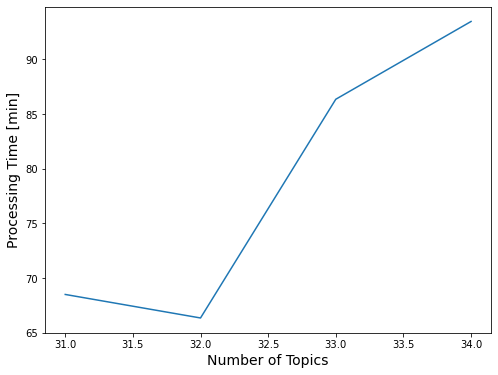

In [24]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [25]:
# Take a look at the resulting coherence scores
coherence_values

[0.6157259960993569, 0.5942393496135262, 0.605285254354468, 0.5962808492435416]

In [26]:
# Take a look at the required processing times (in minutes)
processing_times

[68.4912020166715, 66.33860891660055, 86.35362824996312, 93.47155125141144]

In [27]:
# Take a look at the grid of the number of topics
n_topics

[31, 32, 33, 34]

In [10]:
## 6. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, min_k = 1, max_k = 10, step = 9)

Processing time to build the LDA multicore model with 1 topics: 12.516975327332814 minutes
Coherence Score of the LDA multicore model with 1 topics: 0.2637476645194323
Processing time to build the LDA multicore model with 10 topics: 62.22840309540431 minutes
Coherence Score of the LDA multicore model with 10 topics: 0.5473414609090421


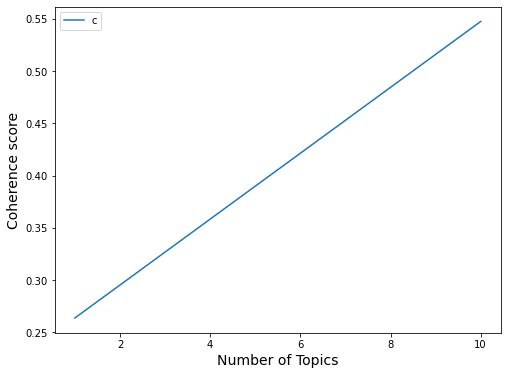

In [11]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

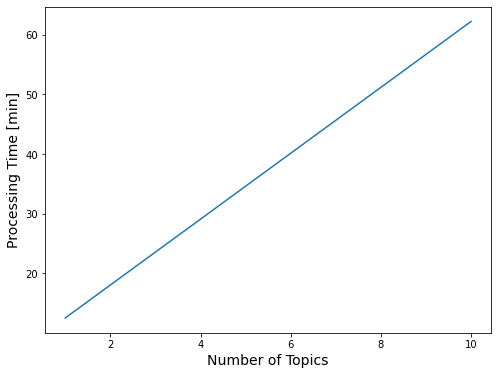

In [12]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [13]:
# Take a look at the resulting coherence scores
coherence_values

[0.2637476645194323, 0.5473414609090421]

In [14]:
# Take a look at the required processing times (in minutes)
processing_times

[12.516975327332814, 62.22840309540431]

In [15]:
# Take a look at the grid of the number of topics
n_topics

[1, 10]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.2 Summarize and Visualize the Results </h2>
</div>

In [5]:
## Storage of the results for LdaMulticore model with passes = 12
# 1. Run
coherence_values = [0.5436379782652139, 0.5616005246306605, 0.6009025786399249, 0.6073096727493481, 0.6094793929624562]
processing_times = [59.8154326359431, 63.79806190729141, 67.81888985236486, 94.76175772746404, 78.93791459004085]
n_topics = [5, 15, 25, 35, 45]

# 2. Run
coherence_values = [0.591490064818739, 0.6017499571769517, 0.6128308575352752, 0.6013447159566319]
processing_times = [62.90475906133652, 67.44095472097396, 95.74181473255157, 80.58396632671356]
n_topics = [20, 30, 40, 50]

# 3. Run
coherence_values = [0.5894477507433086, 0.5834186056684021, 0.5913771484468056, 0.590845458496003]
processing_times = [59.06168606678645, 60.60930094718933, 60.5884538213412, 60.68564414183299]
n_topics = [21, 22, 23, 24]

# 4. Run
coherence_values = [0.6031192464253451, 0.5947736802505857, 0.60564626991718, 0.6040389470852532]
processing_times = [66.64551583925883, 61.93940903743108, 62.77810864845912, 62.763796929518385]
n_topics = [26, 27, 28, 29]

# 5. Run
coherence_values = [0.6157259960993569, 0.5942393496135262, 0.605285254354468, 0.5962808492435416]
processing_times = [68.4912020166715, 66.33860891660055, 86.35362824996312, 93.47155125141144]
n_topics = [31, 32, 33, 34]

# 6. Run
coherence_values = [0.2637476645194323, 0.5473414609090421]
processing_times = [12.516975327332814, 62.22840309540431]
n_topics = [1, 10]


# Joint
coherence_values = [0.2637476645194323, 0.5436379782652139, 0.5473414609090421, 0.5616005246306605, 0.591490064818739, 
                    0.5894477507433086, 0.5834186056684021, 0.5913771484468056, 0.590845458496003,  0.6009025786399249, 
                    0.6031192464253451, 0.5947736802505857, 0.60564626991718,   0.6040389470852532, 0.6017499571769517, 
                    0.6157259960993569, 0.5942393496135262, 0.605285254354468,  0.5962808492435416, 0.6073096727493481, 
                    0.6128308575352752, 0.6094793929624562, 0.6013447159566319]
processing_times = [12.516975327332814, 59.8154326359431, 62.22840309540431, 63.79806190729141,  62.90475906133652, 
                    59.06168606678645, 60.60930094718933, 60.5884538213412,  60.68564414183299,  67.81888985236486, 
                    66.64551583925883, 61.93940903743108, 62.77810864845912, 62.763796929518385, 67.44095472097396, 
                    68.4912020166715,  66.33860891660055, 86.35362824996312, 93.47155125141144,  94.76175772746404, 
                    95.74181473255157, 78.93791459004085, 80.58396632671356]
n_topics = [1,  5,  10, 15, 20, 
            21, 22, 23, 24, 25, 
            26, 27, 28, 29, 30, 
            31, 32, 33, 34, 35, 
            40, 45, 50]

In [6]:
## Fit a logarithmic model to the resulting coherence scores to get a smooth approximation of the learning curve
# Generate the required logarithmic features on the basis of the n_topics variable
X = np.column_stack((n_topics, np.log(n_topics)))
# Set up and fit the logarithmic regression model
reg = linear_model.LinearRegression(fit_intercept = True)
reg.fit(X, coherence_values)
# Get the fitted values for a homogenous grid of 300 values between the maximum and the minimum n_topics
xnew = np.linspace(np.min(n_topics), np.max(n_topics), 300)
coherence_values_smoothed = reg.predict(np.column_stack((xnew, np.log(xnew))))

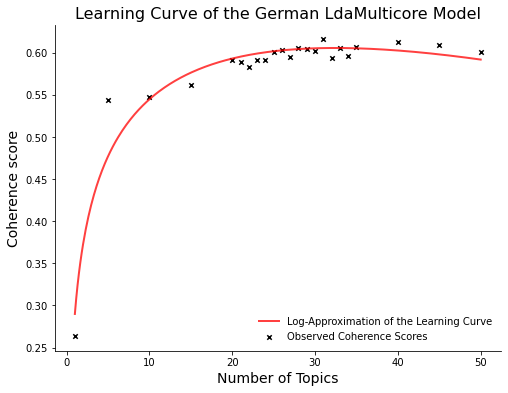

In [7]:
# Show the actual coherence scores obtained together with the smoothly approximated learning curve of the LdaMulticore model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(n_topics, coherence_values, color = 'black', s = 20, marker = 'x', label = 'Observed Coherence Scores')
#ax.plot(n_topics, coherence_values, color = 'black', linewidth = 1.5, alpha = 0.7, linestyle = '--', label = 'True Learning Curve')
ax.plot(xnew, coherence_values_smoothed, color = 'red', linewidth = 2, alpha = 0.75, label = 'Log-Approximation of the Learning Curve')
ax.set(title = "Learning Curve of the German LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Coherence score")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

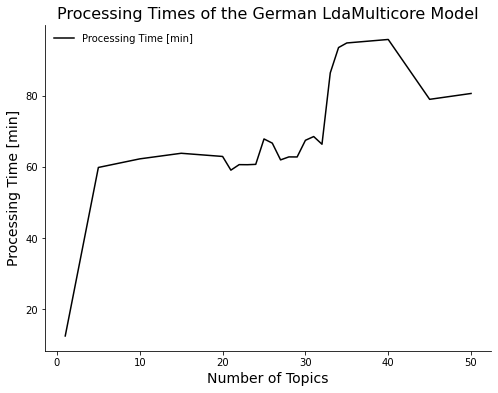

In [8]:
# Show the evolvement of the processing time 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, processing_times, color = 'black', linewidth = 1.5, alpha = 1, linestyle = '-', label = 'Processing Time [min]')
ax.set(title = "Processing Times of the German LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Processing Time [min]")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.3 Determine the optimal K </h2>
</div>

To get a starting point for finding the optimal number of topics $K^*$, we focus on two measures of the estimated models: (1) the coherence score $c(K)$ and (2) the maximal Jaccardian similarity $j(K)$ observed between the top 10 keywords of two of the resulting topics, which is defined by

$$
j(K) = max \left(\frac{|(S_i \cap S_j)|}{|(S_i \cup S_j)|}\right), \ \text{for} \ i \neq j \ \text{and} \ i,j \in \{1,\dots,K\}
$$

where $K$ corresponds to the number of topics in the model and $S_i$ is the set consisting of the top 10 keywords of the $i^{th}$ topic from the model under consideration (note: the maximal Jaccardian similarity measures the highest similarity between two of the resulting topics of a topic model). Our aim is to choose $K$ such that for the corresponding model $c(K)$ is maximized and $j(K)$ is minimized. Since both of these metrics are measured on a scale between 0 and 1, they are directly comparable to each other such that the weighted quality of a model $q_\lambda(K)$ can be measured by the following formula: 

$$
q_\lambda(K) = 2*(\lambda*c(K) - (1-\lambda)*j(K)),
$$

where $\lambda \in [0,1]$ corresponds to the weight assigned to $c(K)$, such that th weight assigned to $j(K)$ is given by $(1-\lambda)$. However, in the present study, we opt for equal weighting of both metrics (i.e. $\lambda = \frac{1}{2}$) to obtain an initial estimate for $K^*$. The topic model relying on the such revealed "optimal" number of topics, $K^*$, is then taken as the first model for the manual review. Then, if the initially selected model appears to deliver too coarse (or too granular) topics, we increase (or decreases) $K$ until a reasonable partitioning is achieved. Furthermore, topic models for which one can reasonably argue that the number of topics is probably too small (e.g. in the context of newspaper articles this would be the case if $K$ is smaller than the number of topics by which most established news outlets sort their articles) are not considered while choosing the opitmal $K$ by means of the approach described above.

In [9]:
# Retrieve the results of the potentially optimal topic models
coherence_values = [0.5473414609090421, 0.5616005246306605, 0.591490064818739, 
                    0.5894477507433086, 0.5834186056684021, 0.5913771484468056, 0.590845458496003,  0.6009025786399249, 
                    0.6031192464253451, 0.5947736802505857, 0.60564626991718,   0.6040389470852532, 0.6017499571769517, 
                    0.6157259960993569, 0.5942393496135262, 0.605285254354468,  0.5962808492435416, 0.6073096727493481, 
                    0.6128308575352752, 0.6094793929624562, 0.6013447159566319]
processing_times = [62.22840309540431, 63.79806190729141,  62.90475906133652, 
                    59.06168606678645, 60.60930094718933,  60.5884538213412,  60.68564414183299,  67.81888985236486, 
                    66.64551583925883, 61.93940903743108,  62.77810864845912, 62.763796929518385, 67.44095472097396, 
                    68.4912020166715,  66.33860891660055,  86.35362824996312, 93.47155125141144,  94.76175772746404, 
                    95.74181473255157, 78.93791459004085,  80.58396632671356]
n_topics = [10, 15, 20, 
            21, 22, 23, 24, 25, 
            26, 27, 28, 29, 30, 
            31, 32, 33, 34, 35, 
            40, 45, 50]

In [10]:
# Define the number of top keywords to use while calculating the Jaccardian similarities between topics
num_keywords = 10

# Create a dictionary to store the LDA models
LDA_models = {}

# Create a dictionary to store the top keywords for each topic of the LDA models
LDA_topics = {}

In [11]:
# Load all desired models and extract the corresponding top keywords for their topics
for i in n_topics:
    # Load the model and store it into the LDA_models dictionary
    LDA_models[i] = gensim.models.ldamodel.LdaModel.load("LDA/de_lda_model_"+str(i)+"_topics")
    # Extract the num_keywords top keywords for each topic from the model with i topics and store them accordingly in the LDA_topics dictionary
    shown_topics = LDA_models[i].show_topics(num_topics = i, 
                                              num_words = num_keywords,
                                              formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [12]:
# Create a function to calculate the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = |(A ∩ B)| / |(A ∪ B)|
    - For LDA, the Goal is a low maximal Jaccard score between the topics of a model
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [13]:
## Apply the above defined function to derive the maximal Jaccardian similarity between the top words of the resulting topics for each model
# Create storage to save the maximal topic similarity for each model
max_topic_similarities = []
# Set up a loop to iterate through all models
for model in n_topics:
    # Create storage to save the topic similarities of all possible topic pairs
    topic_similarities = []
    # Get the topics of the current model
    topics = LDA_topics[model]
    # Set up a loop to calculate the topic similarity for all possible topic pairs
    for i in range(model):
        # Set the maximal topic similarity to 0 for the baseline model, which contains only 1 topic
        if model == 1:
            topic_similarities.append(0)
        # Calculate the topic similarity for all possible topic pairs otherwise
        elif i+1 < model:
            for j in range(i+1,model):
                topic_similarities.append(jaccard_similarity(topics[i], topics[j]))
    # Get the maximal topic similarity of the model and store it within the max_topic_similarities variable
    max_topic_similarities.append(np.max(topic_similarities))

# Take a look at the result
#max_topic_similarities

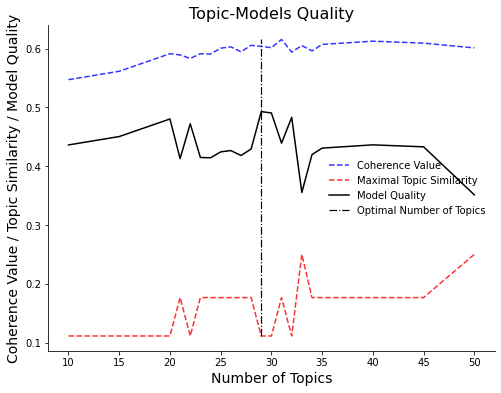

In [14]:
# Calculate the qualities of the models
qualities = np.array(coherence_values) - np.array(max_topic_similarities)

# Calculate the optimal number of topics
opt_n_topic = n_topics[np.argmax(np.array(qualities))]

# Show the development of the coherence scores, the maximal Jaccardian similarities and the model qualities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, coherence_values, color = 'blue', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Coherence Value')
ax.plot(n_topics, max_topic_similarities, color = 'red', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Maximal Topic Similarity')
ax.plot(n_topics, qualities, color = 'black', linewidth = 1.5, alpha = 1, label = 'Model Quality')
ax.plot(np.repeat(opt_n_topic,2), [np.min(max_topic_similarities), np.max(coherence_values)], 
        color = 'black', linewidth = 1.2, alpha = 1, linestyle = '-.', label = 'Optimal Number of Topics')
ax.set(title = "Topic-Models Quality",
       xlabel = "Number of Topics",
       ylabel = "Coherence Value / Topic Similarity / Model Quality")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [15]:
# Display the optimal number of topics
print('The optimal number of topics is', opt_n_topic)

The optimal number of topics is 29


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Inspect the optimal LDA topic model </h2>
</div>

Since manual inspection of the topic model with 29 topics reveals that this model still yields rather coarse topics, we decide to increase $K$ until the corresponding model exhibits reasonably partitioned topics. For the German articles, this strategy leads us to an optimal choice of $K^* = 31$ for the LDA model.

In [5]:
# Load the optimal model from disk and print the topics (adjust the digit appropriately!!!)
opt_n_topic = 31  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/de_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 10, formatted = False)
pprint(optimal_model.print_topics(num_topics = opt_n_topic, num_words = 10))

[(0,
  '0.155*"zürich" + 0.153*"luzern" + 0.100*"zug" + 0.076*"basel" + '
  '0.060*"luzerner" + 0.053*"zürcher" + 0.052*"stadt" + 0.032*"sbb" + '
  '0.028*"zuger" + 0.025*"basler"'),
 (1,
  '0.036*"land" + 0.020*"mensch" + 0.020*"china" + 0.018*"regierung" + '
  '0.012*"staat" + 0.011*"frankreich" + 0.009*"präsident" + 0.008*"million" + '
  '0.008*"europa" + 0.008*"russland"'),
 (2,
  '0.021*"tier" + 0.018*"wasser" + 0.011*"wald" + 0.011*"meter" + 0.010*"baum" '
  '+ 0.010*"grad" + 0.009*"schnee" + 0.009*"winter" + 0.008*"hund" + '
  '0.008*"natur"'),
 (3,
  '0.029*"spieler" + 0.029*"fc" + 0.025*"spiel" + 0.025*"league" + '
  '0.023*"saison" + 0.021*"trainer" + 0.017*"spielen" + 0.016*"liga" + '
  '0.016*"fussball" + 0.014*"team"'),
 (4,
  '0.019*"finden" + 0.017*"musik" + 0.013*"konzert" + 0.013*"publikum" + '
  '0.012*"samstag" + 0.011*"song" + 0.010*"oktober" + 0.010*"november" + '
  '0.010*"bühne" + 0.010*"theater"'),
 (5,
  '0.017*"buch" + 0.014*"leben" + 0.014*"film" + 0.013*"ges

In [6]:
# Read in the preprocessed data
de_tx = read_preprocessed('de')[0]

In [7]:
# Create the corpus again
corpus = [optimal_model.id2word.doc2bow(article) for article in de_tx]

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.155039  0.003859       1        1  10.977230
27     0.032289  0.193903       2        1   5.602476
5      0.113736 -0.085074       3        1   5.045562
17     0.039799  0.100759       4        1   4.656946
30    -0.006413  0.128548       5        1   4.630508
29     0.038740  0.121317       6        1   4.353306
6      0.017267  0.117522       7        1   4.171686
1      0.001755  0.056679       8        1   4.038275
8      0.009800  0.102921       9        1   3.986782
28     0.121805  0.014092      10        1   3.249898
2      0.096663  0.005668      11        1   3.166090
22     0.021452  0.133194      12        1   3.085072
3      0.027367 -0.174139      13        1   3.050822
14     0.019042  0.082620      14        1   3.015700
9      0.052825 -0.112661      15        1   2.937229
21    -0.010737 -0.046299      16        1   2.916423
15     0.071194 -0.161079      17        1   2.913322
4      0.056746 -0.132864      18        1   2.691138
20     0.065281 -0.178242      19        1   2.664010
18    -0.065122  0.170000      20        1   2.544121
10     0.007625  0.006949      21        1   2.510447
7      0.046322 -0.094016      22        1   2.360878
23    -0.039339 -0.000811      23        1   2.238645
24     0.022690  0.045232      24        1   2.007658
26     0.092591 -0.192771      25        1   1.933524
13     0.006213 -0.064866      26        1   1.721654
25     0.027139  0.080415      27        1   1.714648
19    -0.050979  0.040255      28        1   1.692281
16    -0.305219 -0.090162      29        1   1.617212
11    -0.284985  0.040548      30        1   1.432132
0     -0.380585 -0.111498      31        1   1.074327, topic_info=           Term          Freq         Total Category  logprob  loglift
248     schweiz  1.190659e+06  1.190659e+06  Default  30.0000  30.0000
218      kanton  8.759130e+05  8.759130e+05  Default  29.0000  29.0000
202      franke  8.933830e+05  8.933830e+05  Default  28.0000  28.0000
331     prozent  1.187151e+06  1.187151e+06  Default  27.0000  27.0000
77    schweizer  9.304090e+05  9.304090e+05  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
789    sprecher  6.406194e+03  9.074178e+04  Topic31  -5.8815   1.8827
172        bern  1.144096e+04  2.975231e+05  Topic31  -5.3016   1.2752
825    dezember  1.081421e+04  3.495726e+05  Topic31  -5.3579   1.0576
87       stefan  6.381004e+03  1.001871e+05  Topic31  -5.8855   1.7798
1807       genf  5.531009e+03  9.121749e+04  Topic31  -6.0284   1.7306

[1461 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1156      9  0.022041       aarau
1156     13  0.322752       aarau
1156     16  0.090628       aarau
1156     17  0.134612       aarau
1156     19  0.016624       aarau
...     ...       ...         ...
718      24  0.000813  übernehmen
718      25  0.005320  übernehmen
718      27  0.016632  übernehmen
718      28  0.014783  übernehmen
718      30  0.011615  übernehmen

[11408 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 28, 6, 18, 31, 30, 7, 2, 9, 29, 3, 23, 4, 15, 10, 22, 16, 5, 21, 19, 11, 8, 24, 25, 27, 14, 26, 20, 17, 12, 1])

In [9]:
# Delete unnecessary variables
del de_tx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Find the most likely topic for each document </h2>
</div>

In [10]:
# Read in the article indexes
de_idx = read_preprocessed_fulltext('de')[1]

In [11]:
# Define a function to retrieve the topic id of the most likely topic assignment for each article together with the according topic affiliation probability
def get_article_topics(ldamodel, corpus, second_most = False):
    # Create storage to save the id of the assigned topics and the according topic affiliation probabilities
    assigned_topics = []
    affiliation_probs = []
    # Keep track of the processing time
    t = time.time()
    # Get the most dominant topic for each document
    for topic_dist_tuples in ldamodel.get_document_topics(corpus):
        # Get a tuple containing the topic id of the second most dominant topic together with the according topic affiliation probability if second_most = True
        if second_most:
            try:
                topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[1]
            # If the affiliation probability of the second topic is below 0.01, then the topic is ignored and we therefore return a tuple of NAs
            except:
                topic_prob_tuple = (np.nan, np.nan)
        # Get a tuple containing the topic id of the most dominant topic together with the according topic affiliation probability otherwise
        else:
            topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[0]
        # Extract the topic id of the most dominant topic
        assigned_topics.append(topic_prob_tuple[0])
        # Extract the according topic affiliation probability
        affiliation_probs.append(topic_prob_tuple[1])
    # Print out the processing time
    if second_most:
        print("Processing time to retrieve the second most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    else:
        print("Processing time to retrieve the most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    
    # Return the results
    return assigned_topics, affiliation_probs

In [12]:
# Apply the above defined function to get the most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_1, affiliation_prob_1 = get_article_topics(optimal_model, corpus, second_most = False)

Processing time to retrieve the most dominant topic for each article: 17.09057839711507 minutes


In [13]:
# Apply the above defined function to get the second most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_2, affiliation_prob_2 = get_article_topics(optimal_model, corpus, second_most = True)

Processing time to retrieve the second most dominant topic for each article: 16.906907804807027 minutes


In [14]:
# Create a correctly indexed dataframe containing the topic assignment and the according topic affiliation probability
topic_df = pd.DataFrame(assigned_topic_1, index = de_idx.de_idx.values.tolist(), columns = ['Topic_ID_1'])
topic_df['Affiliation_Prob_1'] = affiliation_prob_1
topic_df['Topic_ID_2'] = assigned_topic_2
topic_df['Affiliation_Prob_2'] = affiliation_prob_2
# Save the results to a csv file
topic_df.to_csv("LDA/Topic_Assignment/de_topic_assignment.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Get the most representative articles for each topic (preparation) </h2>
</div>

In [5]:
# Load the optimal model from disk and save the topics' keywords
opt_n_topic = 31  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/de_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 20, formatted = False)

In [6]:
# Read in the Dataframe containing the topic assignments
topic_df = pd.read_csv("LDA/Topic_Assignment/de_topic_assignment.csv", index_col = 0, dtype = {'Topic_ID_1': int, 'Affiliation_Prob_1': float, 'Topic_ID_2': float, 'Affiliation_Prob_2': float})

In [7]:
# Read in the preprocessed fulltext data
de_tx_fulltext, de_idx = read_preprocessed_fulltext('de')

In [8]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5, show_n_last_elements = None):
    # Define the variable show_n_last_elements appropriatly if it is not defined
    if show_n_last_elements == None:
        show_n_last_elements = n_top_articles
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)[(n_top_articles-show_n_last_elements):]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10.1 Display most representative articles for each topic </h2>
</div>

In [9]:
## Topic 0
# Define the id of the topic of interest
id_focal_topic = 0
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 8)

(0,
 [('zürich', 0.15519202),
  ('luzern', 0.1534371),
  ('zug', 0.10048938),
  ('basel', 0.07578142),
  ('luzerner', 0.060226556),
  ('zürcher', 0.052934706),
  ('stadt', 0.051912952),
  ('sbb', 0.03153422),
  ('zuger', 0.02849616),
  ('basler', 0.025187165),
  ('winterthur', 0.021950718),
  ('bahnhof', 0.015917676),
  ('bahn', 0.012150865),
  ('verkehr', 0.007974276),
  ('fahren', 0.0067936373),
  ('linie', 0.006491007),
  ('bus', 0.0061371913),
  ('öffentlich', 0.005794832),
  ('redaktion', 0.0051709116),
  ('bern', 0.004983664)])


[' LUZERN Ab dem Pfingstwochenende bis Dezember 2020 fahren die Züge auf der Gotthardachse nach einem speziellen Fahrplan, dies, weil die Strecke zwischen Zug und Arth Goldau ausgebaut wird. Die Fahrt zwischen der Deutschschweiz und dem Tessin dauert 15 Minuten länger. sda',
 ' Basel. Der ICE, der vergangenen Sonntag zwischen dem Badischen Bahnhof und dem Bahnhof Basel SBB entgleiste, ist wohl wegen einer umgestellten Weiche aus den Schienen gesprungen. Dies sagte ein Experte der nationalen Sicherheitsuntersuchungsstelle (Sust) gestern gegenüber der Tagesschau vonSRF. ',
 '23. 24. MärzFrühlingsaustellung Mercedes Benz Automobil AG, Schlieren, Zürich Seefeld, Zürich Nord, Zollikon, Stäfa und Winterthur. Mercedes Benz, Smart Merbagretail. ch23. 24. MärzFrühlingsausstellung Amag Autowelt Zürich. VW, Audi, Seat, Skoda Autowelt. amag. ch23. 24. MärzFrühlingsausstellung Kenny’s Auto Center, Wettingen. Mercedes Benz, Smart Kennys. ch23. 24. MärzFrühlingsausstellung Emil Frey, Volketswil. Merc

In [10]:
## Topic 1
# Define the id of the topic of interest
id_focal_topic = 1
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(1,
 [('land', 0.036344662),
  ('mensch', 0.020388493),
  ('china', 0.0196271),
  ('regierung', 0.018414281),
  ('staat', 0.011807496),
  ('frankreich', 0.010819218),
  ('präsident', 0.008618616),
  ('million', 0.008351786),
  ('europa', 0.0077682626),
  ('russland', 0.0077467775),
  ('protest', 0.0075416486),
  ('stadt', 0.0073032905),
  ('region', 0.0072020725),
  ('armee', 0.006801259),
  ('italien', 0.0067801173),
  ('welt', 0.0066540875),
  ('türkei', 0.0060599786),
  ('hauptstadt', 0.006032657),
  ('krieg', 0.0058792336),
  ('deutschland', 0.0056469343)])


[' Im blutigen Konflikt in Berg Karabach im Südkaukasus lehnt Armenien eine Vermittlerrolle der Türkei ab. ""Das ist eine seltsame Position"", sagte der armenische Regierungschef Nikol Paschinjan am Freitag der russischen Nachrichtenagentur Interfax. Der aserbaidschanische Präsident Ilham Aliyev hatte zuvor eine Beteiligung seines Verbündeten Türkei ins Gespräch gebracht. Bislang vermittelt die Organisation für Sicherheit und Zusammenarbeit (OSZE) unter dem Vorsitz von Frankreich, Russland und den USA in dem jahrzehntealten Konflikt. ""Die Verhandlungen sollten in diesem Format fortgesetzt werden"", sagte Paschinjan. Das sei auch in einer gemeinsamen Erklärung in Moskau so vereinbart worden. ""Aber Aserbaidschan ändert jedes Mal seine Position. ""Seit Ende September dauern die schweren Gefechte in Berg Karabach an. Aserbaidschan verlor in einem Krieg nach dem Zusammenbruch der Sowjetunion vor rund 30 Jahren die Kontrolle über das bergige Gebiet mit etwa 145 000 Bewohnern. Seit 1994 gal

In [11]:
## Topic 2
# Define the id of the topic of interest
id_focal_topic = 2
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(2,
 [('tier', 0.021377461),
  ('wasser', 0.018377585),
  ('wald', 0.011219862),
  ('meter', 0.010523712),
  ('baum', 0.010487173),
  ('grad', 0.010319223),
  ('schnee', 0.00890537),
  ('winter', 0.008510858),
  ('hund', 0.008460383),
  ('natur', 0.0076662027),
  ('bauer', 0.0069770035),
  ('liegen', 0.006538125),
  ('boden', 0.0063424455),
  ('lassen', 0.006320807),
  ('bild', 0.006316348),
  ('luft', 0.006076805),
  ('temperatur', 0.0060079866),
  ('hoch', 0.0059736376),
  ('kilometer', 0.005941577),
  ('tonne', 0.005865622)])


[' Biskuit, Rahm, Früchte, Schoggi und Caramel Naked Cakes sind süsse Poesie. Nackte Kuchen heissen sie, weil keine Glasur, kein Marzipan oder Fondant den Blick auf das verlockende Innenleben versperrt. — Rezepte, StylingJudith Gmür StalderFotos Maurice K. GrünigBeeren Naked CakeFür eine Springform von 20 bis 22 cm Durchmesser, 9 cm HöheZUTATENBISKUIT5 Eiweiss, 1 Prise Salz, 125 g Zucker, 5 Eigelb, 1 TL Vanillezucker, 110 g MehlFÜLLUNG6 dl Rahm, 1 Päckchen Vanillezucker, etwa 150 g Beerenkonfitüre oder gelee, etwa 250 g gemischte tiefgekühlte BeerenGARNITUREinige Beeren, essbare Blüten (z. B. Rosen, Nelken, Margeriten), wenig Puderzucker (nach Belieben), Mini MeringuesZUBEREITUNG1. Eiweiss mit Salz steif schlagen. Zucker einrieseln lassen, weiterschlagen, bis die Masse glänzt und fest ist. Eigelb und Vanillezucker beifügen, ganz kurz darunterrühren. Mehl dazusieben, sorgfältig mit dem Gummischaber darunterziehen. 2. Den Teig in eine mit Backpapier belegte Form geben, in der unteren Häl

In [12]:
# Further highly ranked articles of topic 2
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 950, show_n_last_elements = 3)

[' Egal, wie gross die Weihnachts schlemmerei ist, ein Dessert muss sein. Unsere fruchtig frischen Kreationen schlagen nicht auf den Magen und auch nicht auf die gute Linie. Text: Pia TeichmannFruchtköpfli mit JoghurtErgibt 4 Silikon Easy Muffinsformen250 g blaue tiefgekühlteFrüchtemischung3,3 dl Apfelsaft1 Beutel Agar Agar100 g griechisches Joghurt nature1 Zweig PfefferminzeVon der Fruchtmischung einige schöne Beeren für die Garnitur in den Tiefkühlschrank legen. Rest der Fruchtmischung mit Apfelsaft und Agar Agar mischen. Unter ständigem Rühren mit dem Schwingbesen aufkochen, 2 3 Minuten köcheln lassen. Alles durch ein feines Sieb streichen. In Silikon oder Puddingförmchen verteilen und im Kühlschrank während mindestens 30 Minuten fest werden lassen. Gelees vorsichtig aus den Formen lösen. Mit Joghurt und restlichen, gefrorenen Beeren anrichten. Mit Pfefferminzblättern dekorieren. Mango Tofu cottaDieses Dessert enthält nur 130 Kalorien und ist eine schlanke Alternative zur herkömmlic

In [13]:
## Topic 3
# Define the id of the topic of interest
id_focal_topic = 3
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(3,
 [('spieler', 0.029040847),
  ('fc', 0.028662875),
  ('spiel', 0.02538245),
  ('league', 0.024830116),
  ('saison', 0.023250666),
  ('trainer', 0.021224987),
  ('spielen', 0.016500684),
  ('liga', 0.016202096),
  ('fussball', 0.015941126),
  ('team', 0.013737812),
  ('mannschaft', 0.013373031),
  ('klub', 0.0119972415),
  ('club', 0.010359147),
  ('yb', 0.009424507),
  ('vertrag', 0.008525802),
  ('stehen', 0.008443045),
  ('fan', 0.008208856),
  ('bayer', 0.0076558576),
  ('verein', 0.007481365),
  ('super', 0.00741628)])


[' Hier finden Sie die wichtigsten Kurzmeldungen des Tages aus dem Schweizer Fussball Geschehen. mir/pro/sdaFCSG holt Kamberi als Itten ErsatzDer FC St. Gallen hat Ersatz für den zu den Glasgow Rangers abgewanderten Cedric Itten gefunden. Vom schottischen Premier Ligisten Hibernian FC stösst Florian Kamberi zu den Ostschweizern. Der 25 jährige Stürmer unterschrieb einen Vertrag bis 2023. Kamberi hat seine Karriere beim FC Rapperswil Jona begonnen, ehe er zu den Grasshoppers wechselte. Via Karlsruhe landete der Schweizer mit kosovarischen Wurzeln bei den Hibs. Zuletzt spielte Kamberi leihweise eine halbe Saison für die Glasgow Rangers. Nuzzolo verlängert bei XamaxXamax kann nach dem Abstieg in die Challenge League weiter auf Raphaël Nuzzolo zählen. Der 37 jährige Stürmer unterschrieb in Neuenburg einen Zweijahresvertrag. Zumindest ein Jahr davon wird Nuzzolo als Spieler absolvieren. Der gebürtige Bieler hat für Xamax bislang über 350 Pflichtspiele bestritten und dabei rund 100 Mal einge

In [14]:
## Topic 4
# Define the id of the topic of interest
id_focal_topic = 4
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(4,
 [('finden', 0.018679177),
  ('musik', 0.016523652),
  ('konzert', 0.012779911),
  ('publikum', 0.012631889),
  ('samstag', 0.0115685165),
  ('song', 0.011214727),
  ('oktober', 0.010446213),
  ('november', 0.010270152),
  ('bühne', 0.010260473),
  ('theater', 0.010250778),
  ('spielen', 0.009867861),
  ('programm', 0.009713082),
  ('singen', 0.009480845),
  ('festival', 0.00934864),
  ('dezember', 0.009187728),
  ('feiern', 0.009159671),
  ('band', 0.008980854),
  ('musiker', 0.008801828),
  ('stehen', 0.0084227035),
  ('sonntag', 0.008329238)])


["von Benjamin Stuber Das coolste Skipisten und Clubfestival der Alpen geht vom 5. bis 7. April 2019 in die zweite Runde. Zwei Täler ein Festival. Das \x93Live is Life\x94 Musikfestival im Skigebiet Arosa Lenzerheide berührt Musikliebhaber mit vielen kleinen und persönlichen Konzerten in einzigartiger Atmosphäre. Weg von übergrossen Bühnen zurück in die erste Reihe und direkt ins Herz.. Tagsüber wird das Skigebiet Arosa Lenzerheide gerockt und abends geht's in den kleinen und feinen Lokalen von Arosa und Lenzerheide weiter. Insgesamt treten 21 nationale und internationale Künstler auf und spielen dabei insgesamt 29 Konzerte. Zu hören gibt es von Pop über Rock hin zu Volkstümlich, Hip Hop und House ganz verschiedene Musikrichtungen für jeden wird es ein musikalisches Highlight zu hören geben. Das Line Up der diesjährigen Ausgabe ist packend und beeindruckend zugleich. Das Publikum hat die einmalige Chance, Künstler wie etwa Marc Sway, James Gruntz Trio, 77 Bombay Street, Manillio, Dodo 

In [15]:
## Topic 5
# Define the id of the topic of interest
id_focal_topic = 5
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(5,
 [('buch', 0.01702943),
  ('leben', 0.013769802),
  ('film', 0.013668665),
  ('geschichte', 0.013342047),
  ('bild', 0.012952984),
  ('welt', 0.011514996),
  ('schreiben', 0.010864475),
  ('the', 0.010763152),
  ('alt', 0.008553614),
  ('zeigen', 0.0075374315),
  ('werk', 0.006997308),
  ('sehen', 0.006418722),
  ('mensch', 0.0061238394),
  ('erzählen', 0.005917003),
  ('roman', 0.005819116),
  ('serie', 0.0056839725),
  ('kunst', 0.005681571),
  ('of', 0.0055516483),
  ('museum', 0.005479057),
  ('frau', 0.005445493)])


[' Von Peter RüediDas Vergangene ist nicht tot; es ist nicht einmal vergangen : Der Satz des grossen William Faulkner drängt sich auf, wenn wir an die Bedeutung denken, die der Blick zurück im heutigen Jazz hat. Der kann durchaus auch Ausgangspunkt für kreative zukunftsgerichtete Entwürfe sein; eine Perspektive der Wahrnehmung. Denn so wahr die Vergangenheit nie tot ist, so unzweifelhaft ist es, dass jede neue Generation eine historische Musik anders hört. Der spirituelle Hallraum oder Überbau, der im Jazz der sechziger Jahre in John Coltranes A Love Supreme gipfelte, sich aber zuvor schon abzeichnete, etwa, fast als Parodie, im kosmischen Klamauk, mit dem sich der Bandleader Sun Ra inszenierte, gewinnt wieder eine neue Attraktivität. Seine jüngste CD nennt der Hammond Organist Joey DeFrancesco (geb. 1971) In the Key of the Universe, und das ist auf den ersten Blick ebenso erstaunlich wie der Umstand, dass er dazu für drei zentrale Titel einen der authentischen Charismatiker jenes spir

In [16]:
## Topic 6
# Define the id of the topic of interest
id_focal_topic = 6
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(6,
 [('prozent', 0.11335452),
  ('zahl', 0.023022264),
  ('hoch', 0.020561837),
  ('liegen', 0.018933048),
  ('steigen', 0.0179356),
  ('stark', 0.01751194),
  ('deutlich', 0.016452702),
  ('zeigen', 0.011459893),
  ('wert', 0.01083766),
  ('vergleich', 0.009660281),
  ('letzt', 0.009360433),
  ('punkt', 0.008893664),
  ('sinken', 0.0088408375),
  ('tief', 0.008702599),
  ('vorjahr', 0.00794313),
  ('erwarten', 0.0075936164),
  ('dürfen', 0.007378808),
  ('monat', 0.0072548855),
  ('rechnen', 0.0068184254),
  ('knapp', 0.00666624)])


[' Die Schweizer Industrie hat im Schlussquartal 2018 nochmals Gas gegeben. Sowohl Produktion als auch Umsatz legten deutlich zu. Dagegen schwächelt der Bau. 22. 02. 2019 10:25In der Schweizer Industrie liess man im letzten Quartal 2018 noch einmal so richtig die Funken sprühen. Bild: BloombergDennoch haben insgesamt Produktion und Umsatz im zweiten Sektor von Oktober bis Dezember zugenommen. Die Produktion kletterte um 3,8 Prozent und der Umsatz um 4,4 Prozent, wie das Bundesamt für Statistik (BFS) am Freitag anhand von provisorischen Ergebnissen bekanntgab. Damit hat die Schweizer Industrie und Bauwirtschaft wieder an Tempo gewonnen, nachdem es im dritten Quartal noch Bremsspuren gegeben hatte. Von Juli bis September hatte die Gesamtproduktion von Industrie und Baugewerbe verglichen mit dem Vorjahresquartal lediglich um 1,1 Prozent zugenommen. Der Umsatz war derweil um 3,3 Prozent gestiegen. Somit geht es nach der Delle aus dem Sommerquartal wieder aufwärts, allerdings ist der Schwun

In [17]:
## Topic 7
# Define the id of the topic of interest
id_focal_topic = 7
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(7,
 [('kind', 0.108244084),
  ('familie', 0.03984636),
  ('eltern', 0.03142719),
  ('schule', 0.030454632),
  ('mutter', 0.0288689),
  ('vater', 0.027223798),
  ('leben', 0.019333307),
  ('schüler', 0.018405685),
  ('jugendliche', 0.01804759),
  ('tochter', 0.015301375),
  ('alt', 0.015134088),
  ('sohn', 0.014179147),
  ('junge', 0.010797695),
  ('lernen', 0.010042956),
  ('haus', 0.009275008),
  ('lehrer', 0.00904686),
  ('mädchen', 0.008871415),
  ('klasse', 0.008716101),
  ('jung', 0.008544771),
  ('schülerin', 0.007733888)])


[' Pfungen Eine Klasse der Sekundarschule Pfungen führte in der Adventszeit ein besonderes Generationenprojekt durch: In Zweiergrüppchen statteten 40 Jugendliche im Alter von 13 und 14 Jahren rund 20 Seniorinnen und Senioren Besuche ab. Es ging darum, miteinander Zeit zu verbringen und sich zu unterhalten. Die Resonanz war gross, sagt Klassenlehrerin Monika Wacker. Die Jungen interessierten sich für das Leben der Alten. Sie erkundigten sich auch danach, wie diese zu ihren Berufen kamen und was früher anders war als heute. (dt) Seite 3',
 ' Ein Leben ohne ihren Vierbeiner Pancake: Das könnten sich Louis Ducruet (26) und seine Frau Marie (26) nicht mehr vorstellen. Denn nur das Beste habe er in ihr Leben gebracht, sagt der Sohn von Monacos Prinzessin Stéphanie (54). Ein Jahr ist es her, seit sie ihn aus einem Tierheim holten. Und vorerst bleibt er ihr alleiniges Baby, da sie noch keine Familie gründen möchten. ',
 ' Fischenthal Ruedi Kaspar, Johanna Utzinger und ihre drei Söhne lebten au

In [18]:
# Further highly ranked articles of topic 7
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 30, show_n_last_elements = 3)

[' Er hat sich entschieden: Francis Fulton Smith (53, Familie Dr. Kleist ) will nicht mehr heiraten. Nach der Scheidung von Verena ist er seit 2018 mit Lebensgefährtin Claudia Hillmeier (Foto) zusammen. Ich bin so glücklich wie noch nie in meinem Leben, dafür brauche ich doch keinen Trauschein, sagt er. ',
 ' Arina Chevallay Denoth ist Engadinerin und lebt mit ihrer Familie in der Romandie. Drei Monate im Jahr verbringt sie aber mit ihren Kindern im Engadin. Die Kinder gehen dann in Scuol zur Schule, sprechen während dieser Zeit nur Romanisch und nehmen aktiv an den Bräuchen und am Dorfleben teil. Mit diesem Lebensmodell hofft Arina Chevallay Denoth, ihren Kindern auch eine romanische Identität vermitteln zu können. Für die Familie aus der Westschweiz ist es die einzige Möglichkeit, Immersion zu machen. Immersives Lernen erhöht gerade bei Kindern, die in einem anderssprachigen Umfeld aufwachsen, die Motivation, Romanisch zu sprechen. (fh) Region Seite 9',
 ' Rothrist Unter der Federfüh

In [19]:
## Topic 8
# Define the id of the topic of interest
id_focal_topic = 8
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(8,
 [('gemeinde', 0.036587436),
  ('projekt', 0.022321012),
  ('stadt', 0.020389676),
  ('gemeinderat', 0.017105691),
  ('stadtrat', 0.010502146),
  ('stehen', 0.008826064),
  ('bau', 0.008216028),
  ('gebäude', 0.007931003),
  ('neu', 0.0077929674),
  ('planen', 0.006936622),
  ('bevölkerung', 0.0069353785),
  ('öffentlich', 0.0061542583),
  ('geplant', 0.0057852366),
  ('zudem', 0.005696738),
  ('bauen', 0.0055648093),
  ('standort', 0.005306085),
  ('neubau', 0.0047124955),
  ('können', 0.0046797716),
  ('platz', 0.004657429),
  ('entstehen', 0.004431551)])


[' Im westlichen Dorfzentrum soll eine Überbauung entstehen. Dafür braucht es eine Zonenplanänderung. Der Gemeinderat Alpnach hat zwei Projekte zur Zentrumsüberbauung lanciert. Überbaut werden soll die Zone im erweiterten Pfisternareal. Mit den betroffenen Grundeigentümern wurde ein Überbauungsplan erstellt. Inhaltlich werde dieser von allen Beteiligten getragen, schreibt der Gemeinderat im Alpnacher Blettli. Das Raumplanungsgesetz verpflichtet zu einer verdichteten Bauweise im bestehenden Siedlungsgebiet. Diese Vorgabe soll mit den beiden Projekten umgesetzt werden. So könne kostbares Kulturland an der Siedlungsperipherie erhalten bleiben, schreibt die Gemeinde. Der Gemeinderat sieht in diesem Hinblick die Verdichtung in den Dorfzentren als besonders wichtig. Es ist die Aufgabe der Gemeinde, für eine Zentrumsüberbauung zu sorgen, und so lancierten wir diese Projekte, sagt Gemeindepräsident Heinz Krummenacher auf Anfrage. Über Zonenplanänderung muss abgestimmt werdenZum einen geht es b

In [20]:
## Topic 9
# Define the id of the topic of interest
id_focal_topic = 9
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(9,
 [('haus', 0.024635715),
  ('restaurant', 0.021715155),
  ('gast', 0.020372353),
  ('hotel', 0.018127166),
  ('stehen', 0.01286941),
  ('wohnung', 0.011101819),
  ('essen', 0.010409336),
  ('weihnachten', 0.008577669),
  ('ort', 0.007835471),
  ('finden', 0.0074600223),
  ('bild', 0.0074077346),
  ('stadt', 0.0073964447),
  ('öffnen', 0.007047095),
  ('zimmer', 0.007034745),
  ('bleiben', 0.006670822),
  ('dorf', 0.0061934926),
  ('tisch', 0.0060820724),
  ('schön', 0.0059173456),
  ('reise', 0.005875887),
  ('familie', 0.005859831)])


[' Die Ferien oder einfach ein Wochenende in den Bergen verbringen? Die Region Surselva ist eingebettet zwischen Rheinquelle und der Rheinschlucht und bietet unzählige Möglichkeiten, die Natur und die Kultur hautnah zu erleben. Durch unberührte Gegenden wandern, in einem idyllischen Bergsee baden, die verschiedenen Bikewege erkunden, die lokalen Spezialitäten geniessen oder einfach die Seele baumeln lassen. Im breiten und sonnigen Seitental der Surselva dem Val Lumnezia befindet sich der kleine Ort Degen. Inmitten des Dorfes ist aus einem ursprünglichen Stall ein bezauberndes, exklusiv eingerichtetes Ferienhaus entstanden. Es bietet Platz für bis zu zehn Personen. Am besten besucht man die Homepage berg loft. ch und lässt sich inspirieren. Das Verwaltungsteam freut sich auf eine Buchungsanfrage. (pd)Berg Loft Privà Punt Crap 85 7145 Degen Telefon 052 723 29 99 www. berg loft. ch www. stauffacher aemisegger. chDas exklusiv eingerichtete Ferienhaus bietet Platz für bis zu zehn Personen. 

In [21]:
## Topic 10
# Define the id of the topic of interest
id_focal_topic = 10
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(10,
 [('svp', 0.05625652),
  ('sp', 0.04517472),
  ('fdp', 0.042317823),
  ('cvp', 0.03630001),
  ('partei', 0.02601857),
  ('nationalrat', 0.024656171),
  ('grüne', 0.021650562),
  ('stimme', 0.014384651),
  ('sitz', 0.013247592),
  ('glp', 0.012634745),
  ('ständerat', 0.011953506),
  ('grüner', 0.010976141),
  ('kantonsrat', 0.010763593),
  ('parlament', 0.010022595),
  ('wahl', 0.008740408),
  ('fraktion', 0.008119206),
  ('nationalrätin', 0.007110873),
  ('rat', 0.0069566783),
  ('präsident', 0.0068150302),
  ('mitte', 0.006625604)])


[" Der Neue Christian Arnold (SVP) holt den Sitz auf Kosten der FDP. Auch der Neue Daniel Furrer (CVP) ist gewählt. Regionaljournal Zentralschweiz, 08. 03. 2020, 15:00 Uhr; sda/fissNach vier Jahren ist die Urner SVP wieder zurück in der Regierung. Bereits im ersten Wahlgang hat Landrat und Landwirt Christian Arnold (SVP) die Wahl geschafft. Er holt den Regierungssitz auf Kosten der FDP. Auch Daniel Furrer (CVP), ebenfalls Landrat und Landwirt, ist neu in den Regierungsrat gewählt und ersetzt Parteikollegin Heidi Z'graggen, die im Herbst in den Ständerat gewählt worden war. Sämtliche fünf Bisherige, die angetreten sind, haben die Wiederwahl geschafft. SchlussresultatKandidatStimmenUrs Janett (FDP, bisher)8756Beat Jörg (CVP, bisher)8555Roger Nager (FDP, bisher)8478Urban Camenzind (CVP, bisher)8298Dimitri Moretti (SP, bisher)6564Christian Arnold (SVP, neu)6442Daniel Furrer (CVP, neu)5743Absolutes Mehr5705Georg Simmen (FDP, neu)4932Pascal Blöchlinger (SVP, neu)3359Die FDP hat einen ihrer d

In [22]:
## Topic 11
# Define the id of the topic of interest
id_focal_topic = 11
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(11,
 [('kanton', 0.2753588),
  ('bern', 0.057508286),
  ('galle', 0.04036089),
  ('regierungsrat', 0.024283966),
  ('berner', 0.020710925),
  ('aargau', 0.020156622),
  ('regierung', 0.01883627),
  ('thurgau', 0.017976712),
  ('person', 0.017647555),
  ('wallis', 0.016936472),
  ('kantonalen', 0.016828747),
  ('solothurn', 0.01636476),
  ('bund', 0.015667127),
  ('galler', 0.015468769),
  ('schwyz', 0.013998346),
  ('graubünden', 0.013115692),
  ('region', 0.01128991),
  ('chur', 0.009584513),
  ('kantonale', 0.008630317),
  ('freiburg', 0.008443975)])


[' Auf den 1. Oktober sind diverse Stabsoffiziere und Hauptleute aus dem Kanton Bern befördert worden. Simon Gehrig aus Walperswil sowie Yves Nussbaum und Valentina Piffaretti aus Port wurden zu Majoren befördert. mt']

In [23]:
# Further highly ranked articles of topic 11
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 9, show_n_last_elements = 3)

[' Total Kanton 37613 25071 18947 8236 2693 2242 1883St. Gallen 5108 4891 1438 2659 509 358 198Eggersriet 190 146 90 48 9 14 7Wittenbach 646 584 264 109 56 66 29Häggenschwil 183 93 66 30 7 4 3Muolen 147 56 53 11 7 7 7Waldkirch 330 228 202 25 12 9 16Andwil 225 167 94 21 12 6 4Gossau 1819 962 740 214 97 54 42Gaiserwald 897 890 280 160 35 23 24St. Gallen 9545 8017 3227 3277 744 541 330Mörschwil 792 240 145 66 22 17 6Goldach 709 516 325 115 52 51 37Steinach 290 147 91 46 19 55 10Berg 101 59 35 25 6 4 2Tübach 167 90 73 15 7 6 2Untereggen 103 84 62 14 13 1 6Rorschacherberg 523 420 257 134 32 24 12Rorschach 409 335 143 149 31 49 8Thal 385 352 349 93 27 28 28Rorschach 3479 2243 1480 657 209 235 111Rheineck 169 174 125 31 19 9 9St. Margrethen 202 178 221 27 19 10 16Au 357 225 327 60 32 24 43Berneck 262 250 396 39 9 13 21Balgach 341 264 209 78 21 22 39Diepoldsau 397 271 310 53 31 20 45Widnau 584 281 442 96 40 32 157Rebstein 262 142 214 50 17 11 38Marbach 135 115 113 34 9 6 28Altstätten 757 444 5

In [24]:
## Topic 12
# Define the id of the topic of interest
id_focal_topic = 12
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 8)

(12,
 [('sehen', 0.011334844),
  ('einfach', 0.011184761),
  ('mensch', 0.010301089),
  ('leben', 0.00966947),
  ('mal', 0.008904209),
  ('leute', 0.00848887),
  ('frage', 0.0077441065),
  ('sagen', 0.0072027673),
  ('denken', 0.0069776885),
  ('finden', 0.0067483755),
  ('brauchen', 0.0063577285),
  ('wichtig', 0.006355658),
  ('weiss', 0.006245594),
  ('sprechen', 0.0057960805),
  ('fragen', 0.005608822),
  ('nehmen', 0.005599263),
  ('stehen', 0.005596737),
  ('bleiben', 0.005574034),
  ('wissen', 0.00552008),
  ('hören', 0.0054396135)])


[' Emma AmourEmma AmourLiebe Erika,ich stolpere ehrlich gesagt etwas über die Aussage Es kam, wie es kommen musste. Nein, es muss nicht zu einer Situation kommen, in der man fremdknutscht. Du bist immer noch die, die entscheidet, ob es dazu kommt oder nicht. Das Leben, auch in einer Beziehung, ist geprägt von Versuchungen und Verlockungen, ja. Die Frage ist, was du daraus machst. Du hast dich ganz klar dazu entschieden, Backstage zu gehen und mit dem Gitarristen rumzumachen. Du schreibst, dass du nicht weisst, warum du das getan hast. Du aber kein schlechtes Gewissen hast. Bist du ganz sicher? Kann es nicht sein, dass dir vielleicht in deiner Partnerschaft doch was fehlt? Zumindest der Kick des Neuen?Und ist es wirklich so, dass du gar kein bisschen ein schlechtes Gewissen hast? Warum nicht? Hast du denn überhaupt mal mit deinem Freund darüber geredet, wo eure Grenzen liegen?Ob du deinem Freund den Kuss beichten sollst, kann ich dir nicht sagen. Aber überlege dir doch mal, ob du es den

In [25]:
## Topic 13
# Define the id of the topic of interest
id_focal_topic = 13
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(13,
 [('frau', 0.15595041),
  ('mann', 0.10905581),
  ('polizei', 0.03777025),
  ('jährig', 0.026871284),
  ('opfer', 0.02111314),
  ('jährige', 0.019022524),
  ('polizist', 0.016594814),
  ('täter', 0.015086457),
  ('gewalt', 0.012568861),
  ('person', 0.0108302655),
  ('staatsanwaltschaft', 0.009544126),
  ('sexuell', 0.009395372),
  ('finden', 0.009378087),
  ('junge', 0.009010036),
  ('alt', 0.00883995),
  ('gefängnis', 0.008629114),
  ('verurteilen', 0.0074395677),
  ('festnehmen', 0.0071054343),
  ('jung', 0.0065394905),
  ('töten', 0.0063624587)])


[' Ein Mädchen ist in Chemnitz von zwei Männern festgehalten worden. Ein Autofahrer konnte Schlimmeres verhindern. Nadine WoznyIn Chemnitz hat ein Autofahrer eine Vergewaltigung verhindert. GoogleEr eilte einem Mädchen in der Carl von Ossietzky Strasse zu Hilfe. GoogleDie Polizei sucht Zeugen. KEYSTONEDarum gehtsEin Autofahrer ist in Chemnitz einem schreienden Mädchen zu Hilfe geeilt. Es wurde von zwei Männern in einem Gebüsch festgehalten. Die Täter konnten flüchten. Ein Autofahrer (34) in Chemnitz (D) hörte plötzlich Schreie eines Mädchens aus einem Gebüsch. Sofort hielt er an, ihm fiel ein Mann am Strassenrand auf. Der 34 Jährige sprach den Mann an. Der Mann war gemäss Polizeimitteilung nicht allein: Daraufhin liess offenbar der zweite von einer Jugendlichen ab, die dann wegrannte. Auch die beiden Männer flüchteten. Der Autofahrer folgte dem Mädchen. Es erklärte, dass die Männer versuchten, sie zu vergewaltigen. Die Jugendliche wurden in einer Strassenbahn angesprochen. Als sie auss

In [26]:
## Topic 14
# Define the id of the topic of interest
id_focal_topic = 14
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(14,
 [('milliarde', 0.028806744),
  ('aktie', 0.026901111),
  ('dollar', 0.026766637),
  ('unternehmen', 0.023960182),
  ('bank', 0.021923827),
  ('usamerikanischen', 0.021217894),
  ('euro', 0.019598631),
  ('konzern', 0.015680999),
  ('ubs', 0.013684865),
  ('banken', 0.013649013),
  ('börse', 0.013574254),
  ('suisse', 0.011809004),
  ('markt', 0.0109531),
  ('anleger', 0.009998688),
  ('investor', 0.009828178),
  ('schweizer', 0.009579522),
  ('chef', 0.008969459),
  ('gewinn', 0.008790056),
  ('credit', 0.007947861),
  ('kurs', 0.0075633847)])


[' Es ist der grösste Börsengang seit dem des Amazon Rivalen Alibaba im Jahr 2014 doch nun bringt der US Fahrdienstvermittler seine Aktien nicht so erfolgreich los wie erhofft. Der mit Spannung erwartete Börsengang des Fahrdienstvermittlers Uber hat den neuen Investoren Kursverluste gebracht. Die Aktien starteten bei ihrem Debüt an der US Techologiebörse Nasdaq am Freitag mit 42 Dollar, mehr als sechs Prozent unter dem Ausgabepreis von 45 Dollar. Schon diesen Wert hatte das vor zehn Jahren gegründete Unternehmen aus Kalifornien nahe dem unteren Ende der Preisspanne von 44 bis 50 Dollar festgelegt. Uber kam auch damit noch auf eine Marktkapitalisierung von mehr als 80 Milliarden Dollar und ist so viel wert wie die deutschen Autobauer BMW und Volkswagen zusammen. Der kleinere Uber Rivale Lyft hatte im März Aktien zu einem Preis von je 72 Dollar platziert, seither ging es mit dem Kurs allerdings fast nur bergab. Am Mittwoch hatten die Titel ein Rekordtief von 52 Dollar erreicht. ',
 ' Der

In [27]:
## Topic 15
# Define the id of the topic of interest
id_focal_topic = 15
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(15,
 [('minute', 0.035139013),
  ('tor', 0.030198235),
  ('spiel', 0.025533125),
  ('sieg', 0.015904047),
  ('punkt', 0.014533275),
  ('team', 0.012637443),
  ('partie', 0.012021354),
  ('niederlage', 0.00839943),
  ('mal', 0.008287028),
  ('treffen', 0.008235374),
  ('lugano', 0.008187028),
  ('letzt', 0.00790378),
  ('erzielen', 0.0078145275),
  ('davos', 0.007798199),
  ('biel', 0.007504915),
  ('treffer', 0.0072869984),
  ('ball', 0.0072091976),
  ('stehen', 0.007184756),
  ('verlieren', 0.0070398664),
  ('gewinnen', 0.0070272703)])


[" Die Lions zittern im Strichkampf trotz des 2:1 Heimsiegs gegen die SCL Tigers weiterhin um einen Playoff Platz. Der Meister liegt punktgleich mit dem neuntplatzierten Fribourg auf Rang 8. Pius Suter verwandelte im Penaltyschiessen den entscheidenden Versuch. Damit verhinderte der Nationalstürmer, dass die ZSC Lions erstmals seit dem 6. Januar und erstmals unter Arno Del Curto unter den Playoff Strich rutschten. Dass für beide Teams viel auf dem Spiel stand, war vor 9059 Zuschauern im Hallenstadion schnell ersichtlich. Die Akteure auf dem Eis agierten nervös, keiner wollte zuerst einen Fehler begehen. Insbesondere der ZSC konnte sich eine weitere Niederlage nicht erlauben, nachdem er zuvor aus acht Spielen nur zwei Siege davongetragen hatte. Den Zürchern gelang es dann auch, durch Fabrice Herzog in der 6. Minute mit 1:0 vorzulegen. Für Herzog war es der dritte Treffer aus den letzten vier Spielen. Danach verpasste es der ZSC aber, nachzulegen. Langnau kam gut zehn Minuten vor dem End

In [28]:
## Topic 16
# Define the id of the topic of interest
id_focal_topic = 16
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(16,
 [('schweiz', 0.27357522),
  ('schweizer', 0.16349825),
  ('deutschland', 0.04474213),
  ('land', 0.040055215),
  ('srf', 0.032342874),
  ('swiss', 0.02796595),
  ('deutsch', 0.018148525),
  ('ausland', 0.017282594),
  ('österreich', 0.016624546),
  ('international', 0.014936274),
  ('zürich', 0.013279966),
  ('genf', 0.012506853),
  ('europa', 0.011201931),
  ('frankreich', 0.010933807),
  ('bern', 0.010151445),
  ('italien', 0.008779581),
  ('schwede', 0.008398191),
  ('schweizerinnen', 0.006686353),
  ('spanien', 0.0061463737),
  ('internationale', 0.0058404296)])


[' Im Jahr 2018 hat die Schweiz 412391 Dosen Rindersperma exportiert und 426773 Dosen importiert. Am meisten Rinder Sperma wird laut den News des Schweizer Bauernverbandes nach Rumänien, Polen und Italien exportiert, die wichtigsten Herkunftsländer von Import Spermadosen sind die USA, Deutschland und Frankreich. sum',
 ' Manche reisen gleich für die ganze Wintersaison nach Mauritius oder Thailand. Der Chef von Emirates Schweiz Juerg Mueller über die neuen Fluggewohnheiten. 9',
 ' Arbeitnehmer werden in der Schweiz in den nächsten zehn Jahren in Pension gehen. Doch nur 500000 neue Arbeitskräfte kommen bis dann nach. Schweiz',
 ' Arbeitnehmer werden in der Schweiz in den nächsten zehn Jahren in Pension gehen. Doch nur 500000 neue Arbeitskräfte kommen bis dann nach. Schweiz',
 ' Arbeitnehmer werden in der Schweiz in den nächsten zehn Jahren in Pension gehen. Doch nur 500000 neue Arbeitskräfte kommen bis dann nach. Schweiz']

In [29]:
# Further highly ranked articles of topic 16
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 200, show_n_last_elements = 2)

[' Die Schweiz und Deutschland treffen sich. Schweiz: Sali!Deutschland: Hallo!Schweiz: Hoi. Deutschland: Na?Schweiz: Schön, bist du hier. Deutschland: Es ist einfach schön bei dir. Schweiz: Gehen wir einen Kaffee go trinken?Deutschland: Gern. Aber nur, wenn wir draussen sitzen. Schweiz: Sicher nicht, bei dem Wetter!Deutschland: Sicher doch, wegen Corona. Schweiz: Ach komm, ich will mir keine Erkältung einfangen. Deutschland: Und ich kein Corona. Schweiz: Jetzt mach keine Panik. Deutschland: Ich weiss nicht... Du bistmir einfach nicht vorsichtig genug. Schweiz: Ich?Deutschland: Du spinnst einfach mit Corona!Schweiz: Ich? Du spinnst mit Corona. Deutschland: Nein, du hast viel zu spät angefangen, überhaupt eine Maske zu tragen. Schweiz: Janu, dafür konnte ich länger allen zulächeln. Deutschland: Du bist zu lang noch in Clubs gegangen. Schweiz: Dafür konnte ich tanzen. Deutschland: Du gehst sogar noch ins Fitnessstudio. Schweiz: Dafür sehe ich besser aus. Deutschland: Auch ins Theater gehs

In [30]:
## Topic 17
# Define the id of the topic of interest
id_focal_topic = 17
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(17,
 [('unternehmen', 0.02329022),
  ('firma', 0.022219624),
  ('kunde', 0.017294414),
  ('produkt', 0.012527985),
  ('migros', 0.008539403),
  ('angebot', 0.008407676),
  ('bieten', 0.007218748),
  ('verkaufen', 0.007155145),
  ('mitarbeitende', 0.0070471503),
  ('markt', 0.0068253237),
  ('neu', 0.0067530526),
  ('preis', 0.0067484644),
  ('mitarbeiter', 0.006061444),
  ('arbeiten', 0.005982974),
  ('schweiz', 0.0057574427),
  ('geschäft', 0.005726389),
  ('modell', 0.0053865095),
  ('bereich', 0.005307098),
  ('setzen', 0.005137885),
  ('wichtig', 0.0050321096)])


[' Wie findet man einen Handwerker, der Qualität bietet? Mit wem haben andere Kunden gute Erfahrungen gemacht?Marktinfo. Auskunft darüber gibt das CertiQua Qualitätslabel. Nur Betriebe, die von ihren Kunden regelmässig Bestnoten bekommen, dürfen dieses Label führen. Die casa technica. ch®, Landolt Gebäudetechnik AG, Näfels, hat diese Auszeichnung kürzlich erhalten sie gehört damit zu den Top Betrieben der Branche. Eine ausgezeichnete Leistung, betont Caroline Roosens von CertiQua, das beweist, dass für die casa technica. ch®, Landolt Gebäudetechnik AG, die Zufriedenheit ihrer Kunden an erster Stelle steht. CertiQua als unabhängige Organisation stellt sicher, dass die Leistung der Betriebe auf Basis echter Kundenfeedbacks bewertet wird. Im Fokus der Befragung stehen die Faktoren Termintreue, Kompetenz, Kundenorientierung, Sauberkeit am Arbeitsplatz sowie Preis Leistungs Verhältnis. Auch nach der Verleihung des Labels überprüft CertiQua kontinuierlich, ob die Kunden weiterhin zufrieden s

In [31]:
## Topic 18
# Define the id of the topic of interest
id_focal_topic = 18
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 9)

(18,
 [('franke', 0.16257077),
  ('million', 0.11740067),
  ('geld', 0.040976487),
  ('kosten', 0.030290222),
  ('milliarde', 0.01623189),
  ('bezahlen', 0.0147704175),
  ('erhalten', 0.0138138635),
  ('budget', 0.013541243),
  ('prozent', 0.012250489),
  ('hoch', 0.011788538),
  ('zahlen', 0.01039092),
  ('betrag', 0.008942642),
  ('beitrag', 0.008109159),
  ('finanziell', 0.008061765),
  ('kredit', 0.0078401975),
  ('höhe', 0.0076649487),
  ('betragen', 0.007580667),
  ('teuer', 0.0073370324),
  ('rechnung', 0.0069948714),
  ('jährlich', 0.0067366143)])


[' Budgetiert hat die Kirchgemeinde Unteriberg Mehrausgaben von 87000 Franken. Die Jahresrechnung 2019 der Kirchgemeinde Unteriberg schloss mit Einnahmen von rund 474000 Franken und Ausgaben von 520000 Franken ab. Die Mehrausgaben betrugen zirka 46000 Franken. Diese wurden dem Eigenkapital belastet. Das Eigenkapital betrug demzufolge per 31. Dezember 2019 344308 Franken. Budgetiert waren Einnahmen von 451000 Franken und Ausgaben von 538000 Franken, was einen Aufwandüberschuss von 87000 Franken ergeben hätte. Der Bestand der Pfarrkirchenstiftung betrug 391500 Franken. Der Zuwachs machte 7500 Franken aus. Der Bestand der Pfarrpfrundstiftung betrug 660000 Franken. Der Zuwachs machte 12000 Franken aus. Steuereinnahmen waren höherEine Punktlandung brachten die Steuereinnahmen bei den natürlichen Personen. Bei den ordentlichen Steuern der Vorjahre konnten 22500 Franken eingenommen werden. Die ordentlichen Steuern des Rechnungsjahres machten 285000 Franken aus. Insgesamt wurden an Steuern der

In [32]:
## Topic 19
# Define the id of the topic of interest
id_focal_topic = 19
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(19,
 [('video', 0.031900607),
  ('kirche', 0.028932666),
  ('app', 0.024496244),
  ('facebook', 0.019290341),
  ('online', 0.018632744),
  ('post', 0.018334875),
  ('medium', 0.017725673),
  ('schreiben', 0.01716621),
  ('instagram', 0.014632821),
  ('plattform', 0.013620794),
  ('twitter', 0.013590656),
  ('internet', 0.013152203),
  ('e', 0.01270285),
  ('zeitung', 0.011901446),
  ('media', 0.01164919),
  ('ch', 0.011319304),
  ('bild', 0.010874557),
  ('mail', 0.010833954),
  ('leser', 0.010620555),
  ('digital', 0.0101216175)])


[' Bitte schicken Sie Texte und Bilder fürs Obwaldner Wochenblatt per E Mail an redaktion@owb. ch, per Post an Redaktion Obwaldner Wochenblatt, Brünigstrasse 118, 6060 Sarnen. Wir bitten Sie, Folgendes zu beachten. Schicken Sie Bilder in Originalgrösse angehängt an Ihr E Mail und mit Angaben zu den Personen auf dem Bild. Verfassen Sie Ihren Bericht nicht in Wir Form. Hinterlassen Sie eine Kontaktadresse mit Telefonnummer für allfällige Rückfragen. Beschränken Sie sich nach Möglichkeit auf 2500 Zeichen. Für telefonische Rückfragen erreichen Sie uns unter der Nummer 041 662 90 70. ',
 ' Ihr Leserbrief mit Ihrer Meinung zum aktuellen Geschehen ist uns willkommen. Vorrang haben Zuschriften, die sich auf aktuelle Artikel beziehen, die nicht mehr als 1500 Zeichen enthalten und uns per E Mail erreichen. Bitte Absender und Artikelbezug (Titel und Ausgabedatum) angeben. Mailadresseleserbriefe@limmattalerzeitung. chDie Redaktion entscheidet über die Auswahl der Leserbriefe und behält sich vor, T

In [33]:
## Topic 20
# Define the id of the topic of interest
id_focal_topic = 20
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(20,
 [('rennen', 0.024459362),
  ('schweizer', 0.017493071),
  ('de', 0.01694613),
  ('ski', 0.01484717),
  ('platz', 0.013446038),
  ('rang', 0.012880961),
  ('saison', 0.012584011),
  ('sport', 0.011550305),
  ('weltcup', 0.011256453),
  ('gewinnen', 0.010184475),
  ('team', 0.009369755),
  ('fahren', 0.009356086),
  ('m', 0.009345916),
  ('training', 0.008939814),
  ('ziel', 0.008544197),
  ('tour', 0.007821415),
  ('wm', 0.007778143),
  ('start', 0.007587953),
  ('athlet', 0.0075721676),
  ('letzt', 0.0075533045)])


[' Dominik Paris hat auch die letzte Abfahrt des Winters gewonnen. Der Italiener triumphierte beim Weltcup Final in Soldeu, musste die kleine Kristallkugel aber Beat Feuz überlassen. Feuz brachte seine Reserve mit einem 6. Platz sicher über die Runden. Auch der Wind konnte Dominik Paris nicht stoppen. Bei wechselhaften Verhältnissen fuhr der 29 jährige Speed Spezialist seinen dritten Abfahrtssieg in Folge im Weltcup und den vierten in diesem Winter ein. Er setzte sich mit der Marge von 34 Hundertsteln und mehr vor dem Norweger Kjetil Jansrud und dem Österreicher Otmar Striedinger durch, der seinerseits Mauro Caviezel um sechs Hundertstel auf Platz vier verwies. Seit einiger Zeitstimmt alles Beat FeuzUnd doch blieb die Krönung für den Südtiroler aus. Die kleine Kristallkugel für den Sieg in der Disziplinen Wertung blieb ihm nämlich verwehrt. Weil es eben einen gab, der zwar weniger Abfahrten gewann ja sogar nur eine , der das Pensum aber mit bestechender Konstanz bewältigte: Beat Feuz. 

In [34]:
## Topic 21
# Define the id of the topic of interest
id_focal_topic = 21
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(21,
 [('präsident', 0.02060694),
  ('mitglied', 0.016942143),
  ('müller', 0.014523681),
  ('peter', 0.014233808),
  ('verein', 0.012792405),
  ('übernehmen', 0.012193825),
  ('neu', 0.01107836),
  ('thoma', 0.010948419),
  ('bild', 0.010316294),
  ('martin', 0.0096169235),
  ('andrea', 0.009154528),
  ('schmid', 0.008664683),
  ('hans', 0.008571801),
  ('amt', 0.008336675),
  ('urs', 0.008292099),
  ('meier', 0.008166175),
  ('markus', 0.0077273273),
  ('arbeit', 0.0066946484),
  ('vorstand', 0.006503454),
  ('daniel', 0.006298846)])


[' Stühlerücken beim Detailhandelsriesen Coop: Joos Sutter wechselt ins Präsidium, den Chefposten übernimmtPhilipp Wyss. SDADas künftige Spitzenteam bei Coop: Philipp Wyss und Joos Sutter. Der Verwaltungsrat des Detailhandelsriesen hat Philipp Wyss als Vorsitzenden der Geschäftsleitung nominiert. Er soll seine neue Position im Mai 2021 übernehme, wie es in einer Mitteilung vom Freitag heisst. Auch auf dem Posten des Verwaltungsratspräsidenten kommt es zu einer Rochade. Der bisherige Coop Chef Joos Sutter soll an der Delegiertenversammlung im kommenden Frühjahr Hansueli Loosli ablösen. Sein Austritt aus dem Gremium auf diesen Termin war bereits vorher bekannt. Bisher war Wyss stellvertretender Vorsitzender und verantwortlich für den Bereich Marketing und Beschaffung. Er ist bereits seit 1997 bei Coop tätig. Seine Nachfolgerin soll Andrea Kramer werden. Joos Sutter hatte das Unternehmen seit 2011 geleitet und war bereits seit 2008 Mitglied der Geschäftsleitung. Hansueli Loosli hatte eben

In [35]:
## Topic 22
# Define the id of the topic of interest
id_focal_topic = 22
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(22,
 [('mensch', 0.023185002),
  ('patient', 0.02226024),
  ('studie', 0.019122867),
  ('impfstoff', 0.015035679),
  ('arzt', 0.014200523),
  ('zeigen', 0.011043845),
  ('universität', 0.009795869),
  ('spital', 0.009612328),
  ('forscher', 0.0075644827),
  ('fall', 0.007347782),
  ('krankheit', 0.0069201807),
  ('medikament', 0.006633752),
  ('alt', 0.006574614),
  ('datum', 0.0062426133),
  ('hoch', 0.0062300856),
  ('person', 0.006221622),
  ('behandlung', 0.0059576617),
  ('gesundheit', 0.0058635864),
  ('risiko', 0.005817642),
  ('schwer', 0.005738384)])


[' Eine neue Messmethode zeigt, dass Konzentrationsspitzen von Pestiziden in Bächen bisher unterschätzt werden. Will man wissen, wie viele Schadstoffe in einem Gewässer sind, entnehmen die Forscher eine Messprobe über 3,5 Tage und analysieren diese im Labor. So zeigt sich ein mittlerer Wert. Nun steht den Forschern des Wasserforschungsinstituts Eawag eine neue Methode zur Verfügung, welche nicht nur einen Mittelwert anzeigt, sondern auch zeitliche Spitzenkonzentrationen des Pestizids. Und diese neue Methode, welche die Eawag Forscher an einem kleinen Bach in einem Landwirtschaftsgebiet angewandt haben, zeigt unerfreuliche Ergebnisse. Das dafür verwendete fahrbare vollautomatisierte Wasserlabor namens MS2field ist zwar erst ein Prototyp, zeigt nach Angaben der Forscher aber bereits zuverlässige Daten. Weil MS2field alle zwanzig Minuten automatisch eine Probe nimmt, aufbereitet und analysiert, konnten erstmals grosse Veränderungen der Pestizidkonzentrationen nachgewiesen werden und das i

In [36]:
## Topic 23
# Define the id of the topic of interest
id_focal_topic = 23
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(23,
 [('auto', 0.036688652),
  ('polizei', 0.02138857),
  ('sda', 0.02098473),
  ('fahrzeug', 0.017132243),
  ('kantonspolizei', 0.015604729),
  ('unfall', 0.014762593),
  ('verletzen', 0.014455247),
  ('gestern', 0.012939972),
  ('fahren', 0.012906267),
  ('mitteilen', 0.012328531),
  ('person', 0.010818803),
  ('flughafen', 0.009539655),
  ('spital', 0.009488724),
  ('schwer', 0.009418206),
  ('bringen', 0.00940475),
  ('nacht', 0.009327759),
  ('jährig', 0.009161561),
  ('brand', 0.009132258),
  ('kommen', 0.009130533),
  ('sonntag', 0.008762034)])


[' Bei einem Autounfall zwischen Schwarzsee und Plaffeien ist am Mittwoch der 16 Jahre alte Beifahrer ums Leben gekommen. Schwarzsee Ein Auto war am Mittwochmittag gegen 12. 15 Uhr auf der Strecke Schwarzsee Plaffeien unterwegs. Bei Zollhaus kam das Fahrzeug von der Strasse ab und prallte auf der rechten Seite mit voller Wucht in die Bäume, die sich einige Meter unterhalb der Strasse befinden. Der 20 Jahre alte Lenker überstand diesen Unfall unverletzt, jedoch erlitt sein Beifahrer schwere Verletzungen. Der 16 Jährige wurde zuerst vor Ort von Rettungssanitätern versorgt und dann per Rega Helikopter in ein Spital geflogen. Dort erlag er seinen Verletzungen, wie die Polizei mitteilt. Noch ist unklar, aus welchen Gründen der Lenker die Herrschaft über sein Fahrzeug verloren hat. Die Behörden haben eine Untersuchung eingeleitet, um die genauen Umstände des Unfalls zu ermitteln. Das Unfallfahrzeug wurde von der Pikett Garage abgeschleppt und in die Verwahrungshalle gebracht. Der Fahrer erli

In [37]:
## Topic 24
# Define the id of the topic of interest
id_focal_topic = 24
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(24,
 [('trump', 0.095438704),
  ('usamerikanischen', 0.06914533),
  ('biden', 0.050714865),
  ('präsident', 0.05057047),
  ('usa', 0.038091313),
  ('donald', 0.028252421),
  ('joe', 0.024229806),
  ('demokrat', 0.01804207),
  ('new', 0.016102953),
  ('trumps', 0.01590961),
  ('washington', 0.014601098),
  ('haus', 0.012401773),
  ('york', 0.011285327),
  ('twitter', 0.010418062),
  ('weissen', 0.009282798),
  ('amerikaner', 0.009184508),
  ('amerika', 0.008384795),
  ('amerikanisch', 0.008286335),
  ('staat', 0.008168976),
  ('bundesstaat', 0.007174265)])


[' US Präsident Donald Trump beharrt auf seiner Darstellung, er habe vom ukrainischen Präsidenten keine Gegenleistungen für US Militärhilfe sowie einen Besuch im Weissen Haus erwartet. Es habe kein Quidproquo gegeben, sagte er noch während der Anhörung des US Botschafters Gordon Sondland vor Journalisten, bevor er nach Texas abflog. Die Hearings im Kongress müssten beendet werden. Sondland belastete den […]US Präsident Donald Trump beharrt auf seiner Darstellung, er habe vom ukrainischen Präsidenten keine Gegenleistungen für US Militärhilfe sowie einen Besuch im Weissen Haus erwartet. Es habe kein Quidproquo gegeben, sagte er noch während der Anhörung des US Botschafters Gordon Sondland vor Journalisten, bevor er nach Texas abflog. Die Hearings im Kongress müssten beendet werden. Sondland belastete den Präsidenten. Es sei allen Involvierten klar gewesen, dass Trump die Ukraine zu Ermittlungen gegen den Sohn des Ex Vizepräsidenten Joe Biden drängen wollte, sagte er. ',
 ' Im US Senat ha

In [38]:
## Topic 25
# Define the id of the topic of interest
id_focal_topic = 25
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(25,
 [('eu', 0.0943222),
  ('grossbritannien', 0.02807406),
  ('johnson', 0.021801736),
  ('brexit', 0.016360804),
  ('britisch', 0.016194193),
  ('london', 0.015816566),
  ('britische', 0.015742827),
  ('brüssel', 0.014060159),
  ('abkomme', 0.013918451),
  ('europäische', 0.01119401),
  ('boris', 0.01087453),
  ('vertrag', 0.010708768),
  ('europäisch', 0.010704598),
  ('verhandlung', 0.010415753),
  ('regierung', 0.010122463),
  ('europa', 0.010024769),
  ('deal', 0.010005563),
  ('kommission', 0.009714561),
  ('staat', 0.00892112),
  ('brite', 0.008598812)])


[' Ein Treffen auf höchster Ebene soll den Brexit Durchbruch bringen. Premier Boris Johnson reist dafür nach Brüssel. agenturen/bers; kurnBei den jüngsten Brexit Verhandlungen hat es nach Angaben der EU undGrossbritanniens keine Einigung gegeben. Es soll aber weiter verhandelt werden. Der britische Premierminister Boris Johnson will in den kommenden Tagen nach Brüssel reisen, um mit EU Kommissionspräsidentin Ursula von der Leyen die schwierigsten Fragen zu klären. Dies teilte die EU Kommission mit. Damit geht das Drama um das Abkommen abermals in die Verlängerung. Es sollte bereits am 1. Januar ratifiziert und in Kraft sein. Die Bedingungen für eine Einigung sind wegen Differenzen bei entscheidenden Punkten noch nicht gegeben, hiess es in einer gemeinsamen Erklärung. Wir haben unsere Chefunterhändler gebeten, eine Übersicht über die bleibenden Differenzen vorzubereiten, damit diese persönlich in den nächsten Tagen besprochen werden können. Ein Sprecher der EU Kommission bestätigte, das

In [39]:
## Topic 26
# Define the id of the topic of interest
id_focal_topic = 26
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(26,
 [('wm', 0.027447855),
  ('gewinnen', 0.021882739),
  ('spiel', 0.019620435),
  ('turnier', 0.016935099),
  ('spielen', 0.0154602425),
  ('em', 0.014019327),
  ('roger', 0.013254771),
  ('team', 0.013196747),
  ('final', 0.013002543),
  ('titel', 0.012444189),
  ('sieg', 0.01195668),
  ('schweizer', 0.011583001),
  ('sda', 0.011165112),
  ('nummer', 0.010498677),
  ('spieler', 0.010207577),
  ('grand', 0.009768936),
  ('stehen', 0.009444186),
  ('open', 0.009441885),
  ('letzt', 0.009247951),
  ('tennis', 0.008202845)])


[' Bei der Rückkehr auf die ATP Tour legt der dreifache Grand Slam Sieger einen Fehlstart hin. Er unterliegt dem italienischen Qualifikanten Lorenzo Musetti in zwei Sätzen. vor 23minAus in der ersten Runde:Wawrinka unterliegt in Rom einem 18 JährigenBei der Rückkehr auf die ATP Tour legt der dreifache Grand Slam Sieger einen Fehlstart hin. Er unterliegt dem italienischen Qualifikanten Lorenzo Musetti in zwei Sätzen. René StaufferStan Wawrinka scheidet in Rom bereits in der ersten Runde aus. Foto: FreshfocusSeit Wochen hatte sich Stan Wawrinka auf Sand vorbereitet, hatte das US Open ausgelassen und sich sogar auf Challenger Turnieren Wettkampfpraxis geholt. Dabei hatte er in Prag sogar den Titel geholt. Doch nun das: Am Italian Open, seinem ersten Turnier auf der ATP Tour seit seiner Viertelfinalniederlage in Acapulco gegen Grigor Dimitrov, verabschiedete sich der einzige Schweizer durch die Hintertür und gegen einen Spieler, der auf diesem Circuit seinen ersten Match überhaupt gewann. 

In [40]:
## Topic 27
# Define the id of the topic of interest
id_focal_topic = 27
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(27,
 [('bundesrat', 0.025182262),
  ('initiative', 0.012843526),
  ('bund', 0.010998307),
  ('massnahmen', 0.010777958),
  ('schweiz', 0.010748955),
  ('fordern', 0.00891711),
  ('gesetz', 0.008673685),
  ('können', 0.0069773537),
  ('gelten', 0.006292628),
  ('frage', 0.0060204263),
  ('wirtschaft', 0.0051770285),
  ('sehen', 0.0050975718),
  ('parlament', 0.004931996),
  ('unternehmen', 0.0049043577),
  ('regel', 0.0047573983),
  ('wichtig', 0.004754232),
  ('lösung', 0.004352128),
  ('politik', 0.004302051),
  ('entscheid', 0.0042359675),
  ('stehen', 0.0042275237)])


[' Die Schweiz sei grundsätzlich gut vorbereitet für die Herausforderung und Anwendung von Künstlicher Intelligenz KI. Zu diesem Schluss kommt ein Bericht, den der Bundesrat in Auftrag gegeben hat. Demnach seien die aktuellen Gesetze ausreichend, um mit den Herausforderungen von KI umzugehen. In manchen Bereichen gäbe es aber Klärungsbedarf, etwa beim Einsatz Künstlicher Intelligenz in der […]Die Schweiz sei grundsätzlich gut vorbereitet für die Herausforderung und Anwendung von Künstlicher Intelligenz KI. Zu diesem Schluss kommt ein Bericht, den der Bundesrat in Auftrag gegeben hat. Demnach seien die aktuellen Gesetze ausreichend, um mit den Herausforderungen von KI umzugehen. In manchen Bereichen gäbe es aber Klärungsbedarf, etwa beim Einsatz Künstlicher Intelligenz in der Mobilität, der Sicherheitspolitik und in der Bildung und Forschung. Diese Fragen würden nun abgeklärt, schreibt der Bundesrat. Zudem werden auf Grundlage des Berichts Leitlinien für den Bund erarbeitet. ',
 ' Die W

In [41]:
## Topic 28
# Define the id of the topic of interest
id_focal_topic = 28
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(28,
 [('wahl', 0.030225573),
  ('stimme', 0.020243779),
  ('partei', 0.020007683),
  ('politisch', 0.017427554),
  ('politik', 0.011374441),
  ('wählen', 0.010294069),
  ('präsident', 0.00958584),
  ('mehrheit', 0.009385041),
  ('kandidat', 0.008703847),
  ('politische', 0.008698671),
  ('stehen', 0.008383624),
  ('demokratie', 0.007969988),
  ('gewinnen', 0.007698282),
  ('politiker', 0.0071998765),
  ('amt', 0.0069236387),
  ('land', 0.0061693424),
  ('wähler', 0.0061223265),
  ('regierung', 0.005848756),
  ('parlament', 0.0053943344),
  ('umfrage', 0.0052725165)])


[' Der konservative Ministerpräsident Benjamin Netanjahu und sein Herausforderer Benny Gantz vom Mitte Bündnis Blau Weiss haben sich beide zu Siegern der Parlamentswahl erklärt. ""Der rechte Block unter Führung des Likud hat eindeutig gesiegt"", sagte Netanjahu am Dienstagabend. ""Ich danke den israelischen Bürgern für ihr Vertrauen. Ich werde noch heute Nacht damit beginnen, gemeinsam mit meinen natürlichen Partnern eine rechte Regierung aufzubauen. ""09. 04. 2019 21:37Gantz und sein Mitstreiter Jair Lapid erklärten gemeinsam: ""Wir haben gesiegt! (... ) Diese Wahl hat einen klaren Sieger und einen klaren Verlierer. Netanjahu hat 40 Sitze versprochen und verloren. ""Zwei Fernsehsender sahen das rechte Lager mit Netanjahus konservativem Likud, den strengreligiösen Parteien und den rechten Parteien mit 64 bis 66 Mandaten klar vorn. Das Mitte Links Lager mit Gantz\' Bündnis Blau Weiss, der Arbeitspartei, der linken Merez Partei und den arabischen Parteien erhielt dabei 54 bis 56 Mandate.

In [42]:
## Topic 29
# Define the id of the topic of interest
id_focal_topic = 29
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(29,
 [('fall', 0.021720726),
  ('gericht', 0.01457642),
  ('vorwurf', 0.0098385215),
  ('urteil', 0.009425656),
  ('verfahren', 0.009141422),
  ('behörde', 0.00845778),
  ('schreiben', 0.007898525),
  ('anwalt', 0.0064055854),
  ('bestätigen', 0.006218362),
  ('bericht', 0.0061866306),
  ('frage', 0.0061359284),
  ('staatsanwaltschaft', 0.006020403),
  ('zeitung', 0.0059248335),
  ('stehen', 0.005923901),
  ('monat', 0.005898082),
  ('richter', 0.005699879),
  ('handeln', 0.0056849867),
  ('stellen', 0.0056679905),
  ('geben', 0.005522846),
  ('untersuchung', 0.005443831)])


[' Nach Vorwürfen wegen mutmasslicher Missstände am Bundesstrafgericht in Bellinzona (BStrGer) hat die Aufsicht eine Untersuchung eingeleitet. Die Verwaltungskommission des Bundesgerichts habe am 6. Januar ein aufsichtsrechtliches Verfahren eröffnet. Bundesgerichtssprecher Peter Josi bestätigte einen Bericht der Tamedia Zeitungen. Worum es genau geht, will das Bundesgericht derzeit nicht sagen. Bloss soviel: Man werde auch Einvernahmen mit beteiligten Personen […]Nach Vorwürfen wegen mutmasslicher Missstände am Bundesstrafgericht in Bellinzona (BStrGer) hat die Aufsicht eine Untersuchung eingeleitet. Die Verwaltungskommission des Bundesgerichts habe am 6. Januar ein aufsichtsrechtliches Verfahren eröffnet. Bundesgerichtssprecher Peter Josi bestätigte einen Bericht der Tamedia Zeitungen. Worum es genau geht, will das Bundesgericht derzeit nicht sagen. Bloss soviel: Man werde auch Einvernahmen mit beteiligten Personen durchführen. In den vergangenen Monaten hatten verschiedene Medien unt

In [43]:
## Topic 30
# Define the id of the topic of interest
id_focal_topic = 30
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(30,
 [('corona', 0.05460268),
  ('pandemie', 0.023638975),
  ('covid', 0.019031331),
  ('massnahmen', 0.017079381),
  ('coronavirus', 0.015834615),
  ('woche', 0.015710952),
  ('virus', 0.014705802),
  ('person', 0.013964303),
  ('lockdown', 0.011553938),
  ('maske', 0.010981925),
  ('krise', 0.0106502045),
  ('quarantäne', 0.010349344),
  ('fall', 0.009830271),
  ('gelten', 0.0092519885),
  ('test', 0.008936349),
  ('positiv', 0.008832418),
  ('testen', 0.0080523025),
  ('bleiben', 0.007785955),
  ('situation', 0.007714763),
  ('bag', 0.00747228)])


[' Letzte Woche wurden in einem Pflegeheim im Siviriez/FR 37 Personen positiv auf das Coronavirus getestet. Inzwischen sind dort 53 Menschen infiziert und sieben gestorben, wie die Freiburger Gesundheitsdirektion mitteilt. Bei 34 Infizierten handle es sich um Bewohnerinnen und Bewohner, 19 seien Angestellte des Heims. Weil sich so viele Angestellte mit dem Virus angesteckt haben, hat […]Letzte Woche wurden in einem Pflegeheim im Siviriez/FR 37 Personen positiv auf das Coronavirus getestet. Inzwischen sind dort 53 Menschen infiziert und sieben gestorben, wie die Freiburger Gesundheitsdirektion mitteilt. Bei 34 Infizierten handle es sich um Bewohnerinnen und Bewohner, 19 seien Angestellte des Heims. Weil sich so viele Angestellte mit dem Virus angesteckt haben, hat der Kantonsarzt verfügt, dass die Heimbewohnerinnen und bewohner ins Spital überwiesen werden. Ebenfalls einen Corona Ausbruch melden die Freiburger Behörden aus einem Heim in Bulle. Dort seien insgesamt 34 Corona Fälle nachge

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Topic Distribution </h2>
</div>

In [44]:
# Get the topics and the according counts
topics, counts = np.unique(topic_df.Topic_ID_1, return_counts = True)
print(topics)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[  3862  85786  65422  69788  83611 121127  71156  25061 116406  48430
  51520   6022 172234  29907  61374  64557   2909  93219  29243  18935
  68564  49742  45825  89636  35084  29681  44080 118476  45934 103178
  83544]


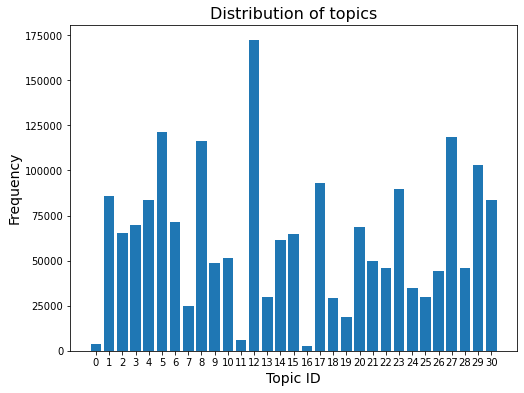

In [45]:
# Plot the topic distribution
plt.title("Distribution of topics")
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.bar(topics, counts, align = 'center')
plt.gca().set_xticks(topics)
plt.show()